In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from matplotlib.animation import PillowWriter

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal,HeUniform,GlorotNormal,GlorotUniform
from tensorflow.keras.regularizers import l2

# 데이터 불러오기

### AI hub 에서 제공한 train,test csv 파일에서 target 데이터의 분포가 맞지 않아 병합 후 사용하도록 하겠습니다.

In [2]:
warnings.filterwarnings(action = 'ignore')
plt.style.use('ggplot')
plt.rc('font',family = 'malgun gothic')
plt.rc('axes',unicode_minus = False)

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/yonghyeun/Dementia_Analysis/main/data/train.csv').drop('EMAIL',axis = 1)
test = pd.read_csv('https://raw.githubusercontent.com/yonghyeun/Dementia_Analysis/main/data/test.csv').drop('EMAIL',axis = 1)

df = pd.concat([train,test],axis = 0)

In [4]:
X = df.drop('target',axis = 1)
Y = df['target']

x_train, x_test, y_train,y_test = train_test_split(X,Y,random_state = 42, test_size = 0.2, stratify = Y)

In [5]:
x_train['target'] = y_train
x_test['target'] = y_test

df = x_train.copy().reset_index(drop = True)
test = x_test.copy().reset_index(drop = True)

# 데이터 분포 확인하기 

Text(0.5, 1.0, 'Target 데이터의 도수 분포표')

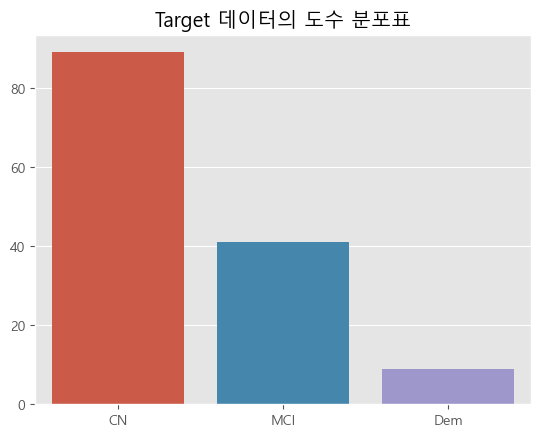

In [6]:
sns.countplot(data = df,
                x = 'target')
plt.xlabel('')
plt.ylabel('')

plt.title('Target 데이터의 도수 분포표')

* 기본적으로 데이터간의 불균형이 존재합니다.

# Cross table 생성하기

In [7]:
activity_cols = ['activity_average_met', 'activity_cal_active', 'activity_cal_total',
       'activity_daily_movement', 'activity_high', 'activity_inactive',
       'activity_inactivity_alerts', 'activity_low', 'activity_medium',
       'activity_met_min_high', 'activity_met_min_inactive',
       'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
       'activity_rest', 'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps', 'activity_total','target']

sleep_cols = ['sleep_awake', 'sleep_breath_average', 'sleep_deep', 'sleep_duration',
       'sleep_efficiency', 'sleep_hr_average', 'sleep_hr_lowest', 'sleep_light', 
       'sleep_midpoint_at_delta','sleep_midpoint_time', 'sleep_onset_latency', 'sleep_period_id',
       'sleep_rem', 'sleep_restless', 'sleep_rmssd', 'sleep_score',
       'sleep_score_alignment', 'sleep_score_deep', 'sleep_score_disturbances',
       'sleep_score_efficiency', 'sleep_score_latency', 'sleep_score_rem',
       'sleep_score_total', 'sleep_temperature_delta',
       'sleep_temperature_deviation', 'sleep_total','target']

In [8]:
def cross_tab(df):
    
    mean_ctab = round(df.groupby('target').mean(),2).astype(str)
    
    sd_ctab = round(df.groupby('target').std(),2).astype(str)
    
    result = mean_ctab + ' (±' + sd_ctab + ')'
    
    return result.T

In [9]:
activity_ctab = cross_tab(df[activity_cols])
sleep_ctab = cross_tab(df[sleep_cols])

In [10]:
display(activity_ctab)
print('**'* 40)
display(sleep_ctab)

target,CN,Dem,MCI
activity_average_met,1.48 (±0.13),1.29 (±0.1),1.49 (±0.14)
activity_cal_active,481.06 (±193.43),256.72 (±140.67),498.22 (±207.1)
activity_cal_total,2526.92 (±266.07),2240.84 (±170.37),2560.97 (±243.1)
activity_daily_movement,9089.44 (±3677.35),4674.78 (±2664.08),9353.74 (±4062.57)
activity_high,3.55 (±5.86),0.84 (±1.37),3.62 (±6.53)
activity_inactive,516.66 (±89.53),540.58 (±115.33),510.16 (±109.6)
activity_inactivity_alerts,0.52 (±0.44),0.64 (±0.55),0.4 (±0.31)
activity_low,289.75 (±82.97),166.87 (±75.66),295.37 (±91.23)
activity_medium,52.54 (±28.19),30.3 (±26.27),58.24 (±38.38)
activity_met_min_high,24.86 (±42.18),6.37 (±10.51),24.21 (±41.68)


********************************************************************************


target,CN,Dem,MCI
sleep_awake,5260.04 (±1700.35),7576.19 (±3311.8),5807.98 (±1649.19)
sleep_breath_average,16.7 (±1.12),16.45 (±0.92),16.82 (±1.0)
sleep_deep,5239.77 (±2002.79),4356.99 (±1871.28),5027.01 (±1937.13)
sleep_duration,28702.54 (±3776.91),34950.81 (±5112.72),28702.74 (±3419.8)
sleep_efficiency,82.28 (±4.9),79.39 (±7.51),80.3 (±5.53)
sleep_hr_average,60.58 (±6.63),58.6 (±6.64),59.94 (±6.66)
sleep_hr_lowest,55.15 (±5.93),52.68 (±6.23),54.8 (±6.23)
sleep_light,14407.68 (±2587.89),18993.43 (±2803.44),14456.01 (±2591.14)
sleep_midpoint_at_delta,11280.48 (±6701.95),16732.37 (±15745.66),10229.5 (±5763.09)
sleep_midpoint_time,14434.61 (±2017.33),17570.04 (±2775.41),14381.85 (±1679.34)


# 통계적 가설검정

### ANOVA TEST

In [11]:
def anova_test(df):
    
    selector = SelectKBest(score_func = f_classif)
    
    X = df.drop('target',axis = 1)
    Y = df['target']
    
    selector.fit(X,Y)
    
    result = pd.DataFrame({'F-statics':selector.scores_,
                            'p-value':selector.pvalues_}, index = selector.feature_names_in_).sort_values(by = 'p-value')
    
    
    return result 

In [12]:
activity_anova = anova_test(df[activity_cols])
sleep_anova = anova_test(df[sleep_cols])

In [13]:
def merge_ctab_anova(ctab,anova):
    
    result = pd.merge(ctab,anova,left_index = True, right_index = True).sort_values(by = 'p-value')
    
    result = result[['CN','MCI','Dem','F-statics','p-value']]
    
    return result

In [14]:
activity_result = merge_ctab_anova(activity_ctab,activity_anova)
sleep_result = merge_ctab_anova(sleep_ctab,sleep_anova)

In [15]:
display(activity_result)
print('**'*50)
display(sleep_result)

,CN,MCI,Dem,F-statics,p-value
activity_score_meet_daily_targets,77.0 (±25.97),79.7 (±22.05),32.1 (±24.96),14.468764,0.000002
activity_rest,524.21 (±87.15),516.05 (±70.33),656.32 (±91.97),11.253629,0.000030
activity_score,82.84 (±9.86),83.74 (±10.11),66.92 (±14.73),10.560889,0.000055
activity_score_training_volume,88.98 (±14.18),89.37 (±15.26),63.8 (±31.14),10.551542,0.000055
activity_total,345.84 (±97.65),357.24 (±107.1),198.02 (±88.11),9.831410,0.000103
activity_low,289.75 (±82.97),295.37 (±91.23),166.87 (±75.66),9.094259,0.000196
activity_met_min_low,200.57 (±68.23),198.64 (±67.47),102.39 (±44.39),8.981034,0.000217
activity_average_met,1.48 (±0.13),1.49 (±0.14),1.29 (±0.1),8.921199,0.000229
activity_steps,10896.37 (±3879.29),11533.6 (±4762.84),6125.17 (±3297.73),6.437075,0.002133
activity_daily_movement,9089.44 (±3677.35),9353.74 (±4062.57),4674.78 (±2664.08),6.142558,0.002793


****************************************************************************************************


,CN,MCI,Dem,F-statics,p-value
sleep_light,14407.68 (±2587.89),14456.01 (±2591.14),18993.43 (±2803.44),12.990114,0.000007
sleep_duration,28702.54 (±3776.91),28702.74 (±3419.8),34950.81 (±5112.72),11.564572,0.000023
sleep_midpoint_time,14434.61 (±2017.33),14381.85 (±1679.34),17570.04 (±2775.41),10.688365,0.000049
sleep_score_latency,79.87 (±3.9),80.18 (±3.28),74.28 (±6.24),8.959065,0.000221
sleep_total,23442.49 (±3162.67),22894.77 (±3213.02),27374.62 (±3580.59),7.320295,0.000956
sleep_awake,5260.04 (±1700.35),5807.98 (±1649.19),7576.19 (±3311.8),7.101472,0.001165
sleep_onset_latency,714.2 (±205.61),667.37 (±160.29),958.36 (±461.19),6.598883,0.001840
sleep_restless,35.38 (±9.33),36.15 (±10.06),45.6 (±10.27),4.634888,0.011291
sleep_score_total,70.95 (±12.16),69.14 (±12.37),81.66 (±11.29),3.929183,0.021931
sleep_score_alignment,90.08 (±11.66),94.43 (±6.01),86.51 (±16.75),3.195057,0.044057


<aside>
💡 INSIGHT

1. 세 그룹간 유의미한 차이가 있던 변수는 다음과 같았습니다.

- 하루 휴식 시간
- 활동 목표 달성 점수
- 활동 점수
- 저강도 운동 시간

2. 비 치매군 (CN) 과 경도 인지 장애군(MCI)의 독립 변수간의 차이는 크게 나지 않았습니다. 위 4가지의 변수들은 치매군(Dem) 와 다른 환자 군간 차이가 유의미하게 나타났습니다.

 MCI 군과 Dem 군을 합쳐 하나의 치매 군으로 보고 T-test 검정을 시행한다면 유의미한 차이가 나는 변수들은 달라질 것 같습니다.

 두 변수를 합쳐야 할지 말아야 할지 고민을 해봐야겠습니다.

</aside>

<aside>
💡 INSIGHT

1. 세 그룹간 유의미한 차이가 있던 변수는 다음과 같았습니다.

- 가벼운 수면 시간
- 수면 잠복 점수
- 수면 중간점 시간
- 수면 시간 
- 수면 잠복 시간 
- 뒤척임 비율
- 수면 시기 점수 
- 수면 시간 
- 깊은 수면 점수 
- 깬 시간

2. 수면 양상 데이터에서는 활동 내역 데이터와 다르게 세 그룹간의 차이가 나타났습니다.
대부분 부정적인 양상은 Dem → MCI → CN 군, 긍정적인 양상은 CN →MCI → Dem 순으로 나타났습니다. 

 하지만 anova test 에서는 각 그룹 간의 차이가 있다 정도만 알 수 있을 뿐 제대로 된 통계 검정을 위해서는 다른 절차가 필요 할 것입니다.

</aside>

In [16]:
activity_pvalue = activity_result[activity_result['p-value'] < 0.05]
sleep_pvalue = sleep_result[sleep_result['p-value'] < 0.05]

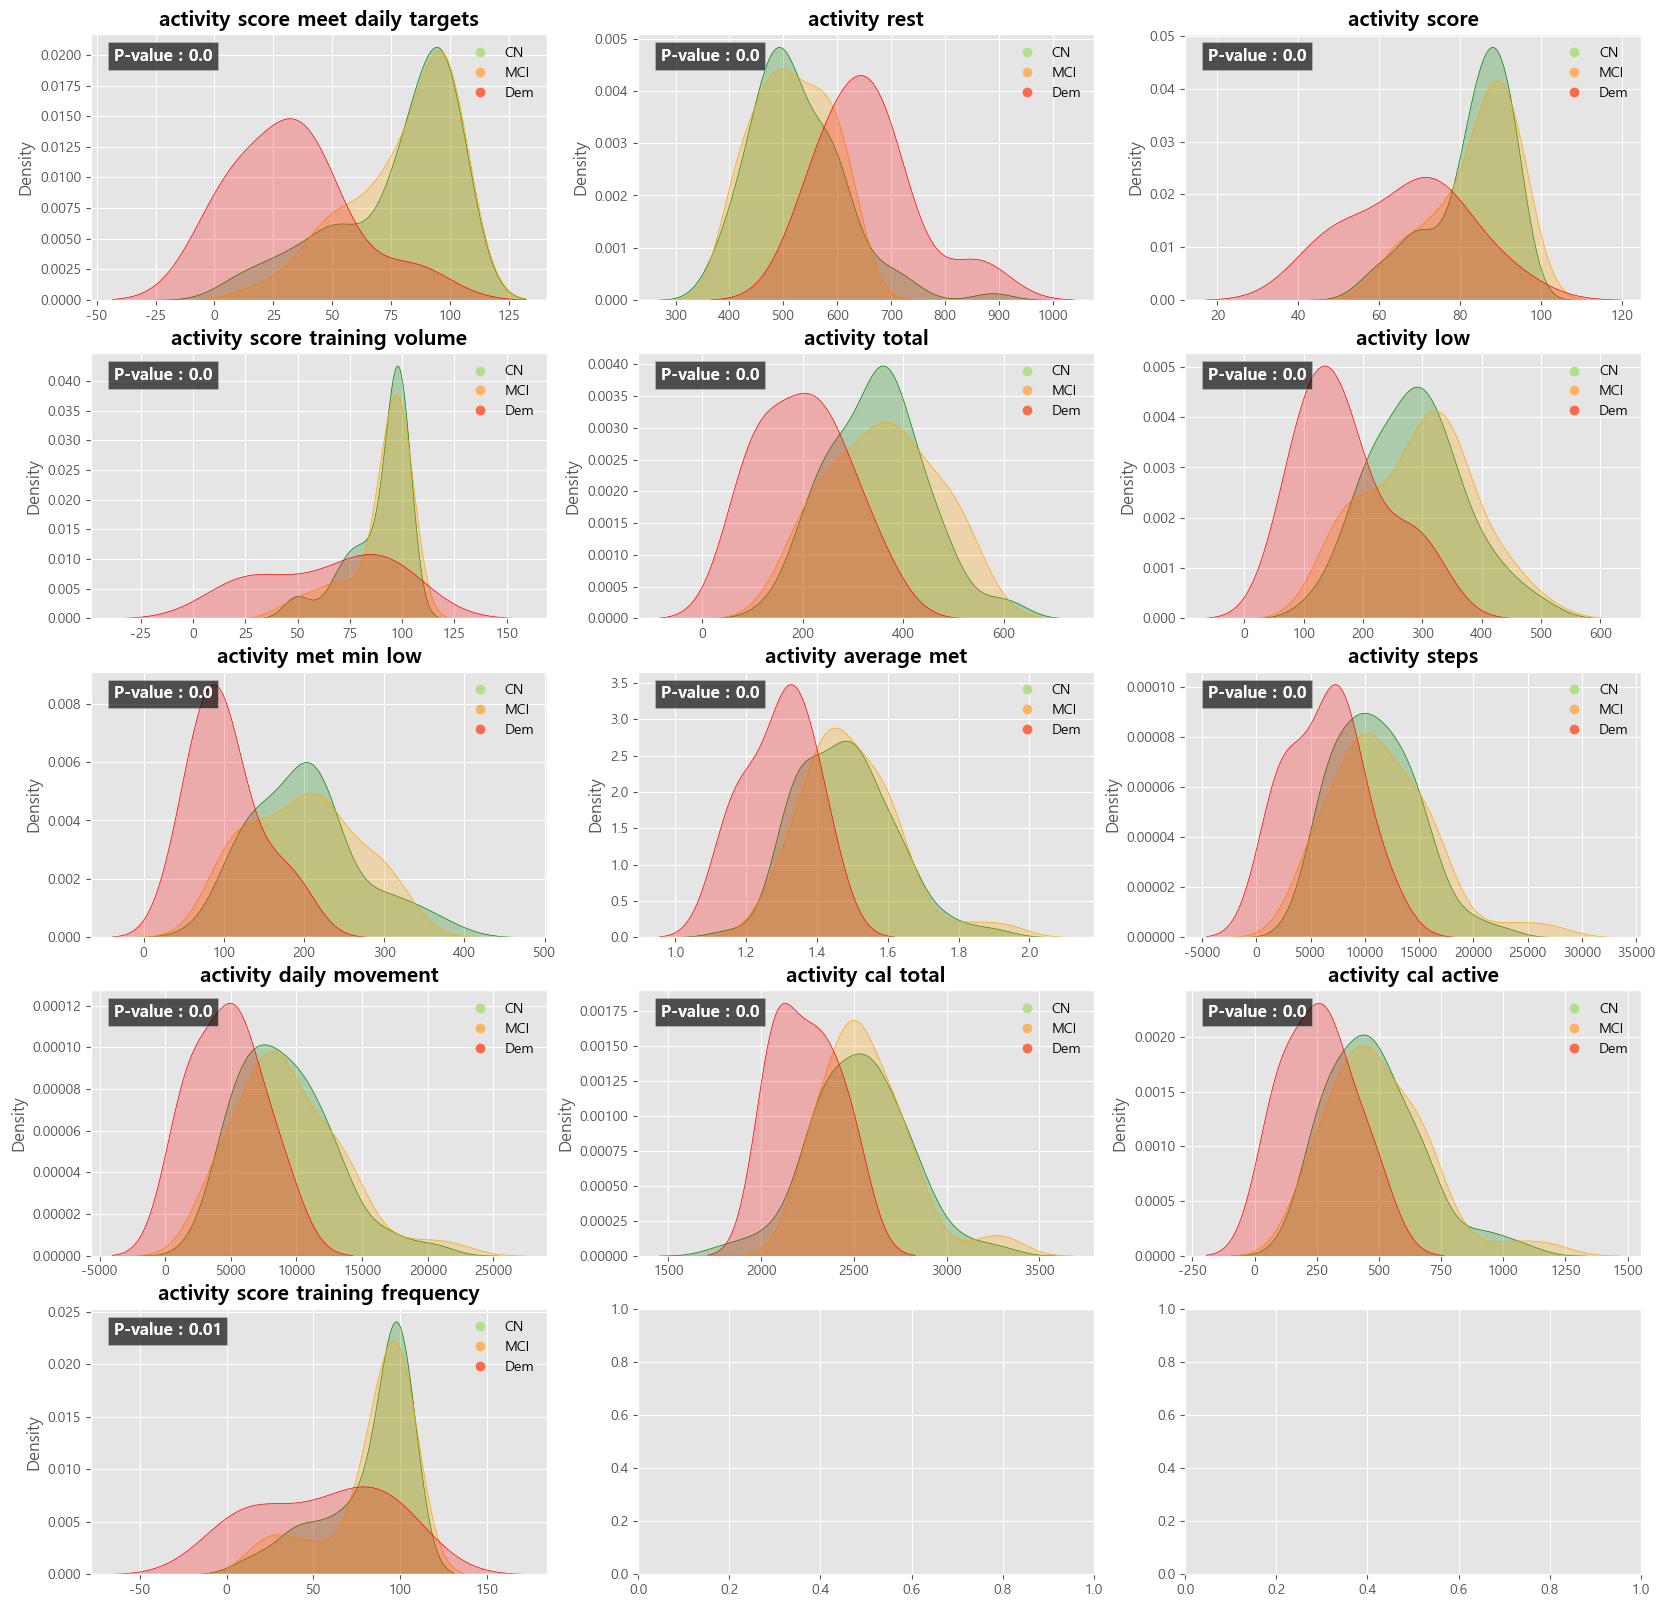

In [17]:
fig,ax = plt.subplots(ncols = 3,nrows = 5, figsize = (20,20))

target_colors = {'CN':'#b2df8a','MCI':'#fdb462','Dem':'#fb6a4a'}

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle = ' ') 
                        for label, color in target_colors.items()]

ax = ax.flatten()

colors = ['green','orange','red']

p_value = activity_pvalue['p-value'].values
cols = activity_pvalue.index

for i,col in enumerate(cols):
    for num,target in enumerate(['CN','MCI','Dem']):
        
        
        p = round(p_value[i],2)

        sns.kdeplot(data = df[df['target'] == target],
                    x = col,
                    ax = ax[i],
                    fill = True,
                    color = colors[num])
        ax[i].set_xlabel('')
        ax[i].set_title(col.replace('_',' '), fontsize = 15, weight = 'bold')
        ax[i].legend(handles = legend_elements,
                    frameon = False,
                    loc = 'upper right')
        # add text to ax
        ax[i].text(0.05, 0.9, f'P-value : {p}', transform=ax[i].transAxes, fontsize=12, fontweight='bold', color='white', bbox=dict(facecolor='black', alpha=0.3))

<aside>
💡 INSIGHT

 **치매군 환자**들이 **비 치매군**과 **경도 인지 장애군**에 비해 휴식 시간이 많았고, 하루 활동 점수 및 저강도 운동 시간이 매우 낮았습니다.

 **비 치매군**과 **경도 인지 장애군**간의 평균적인 차이는 보이지 않습니다.

</aside>

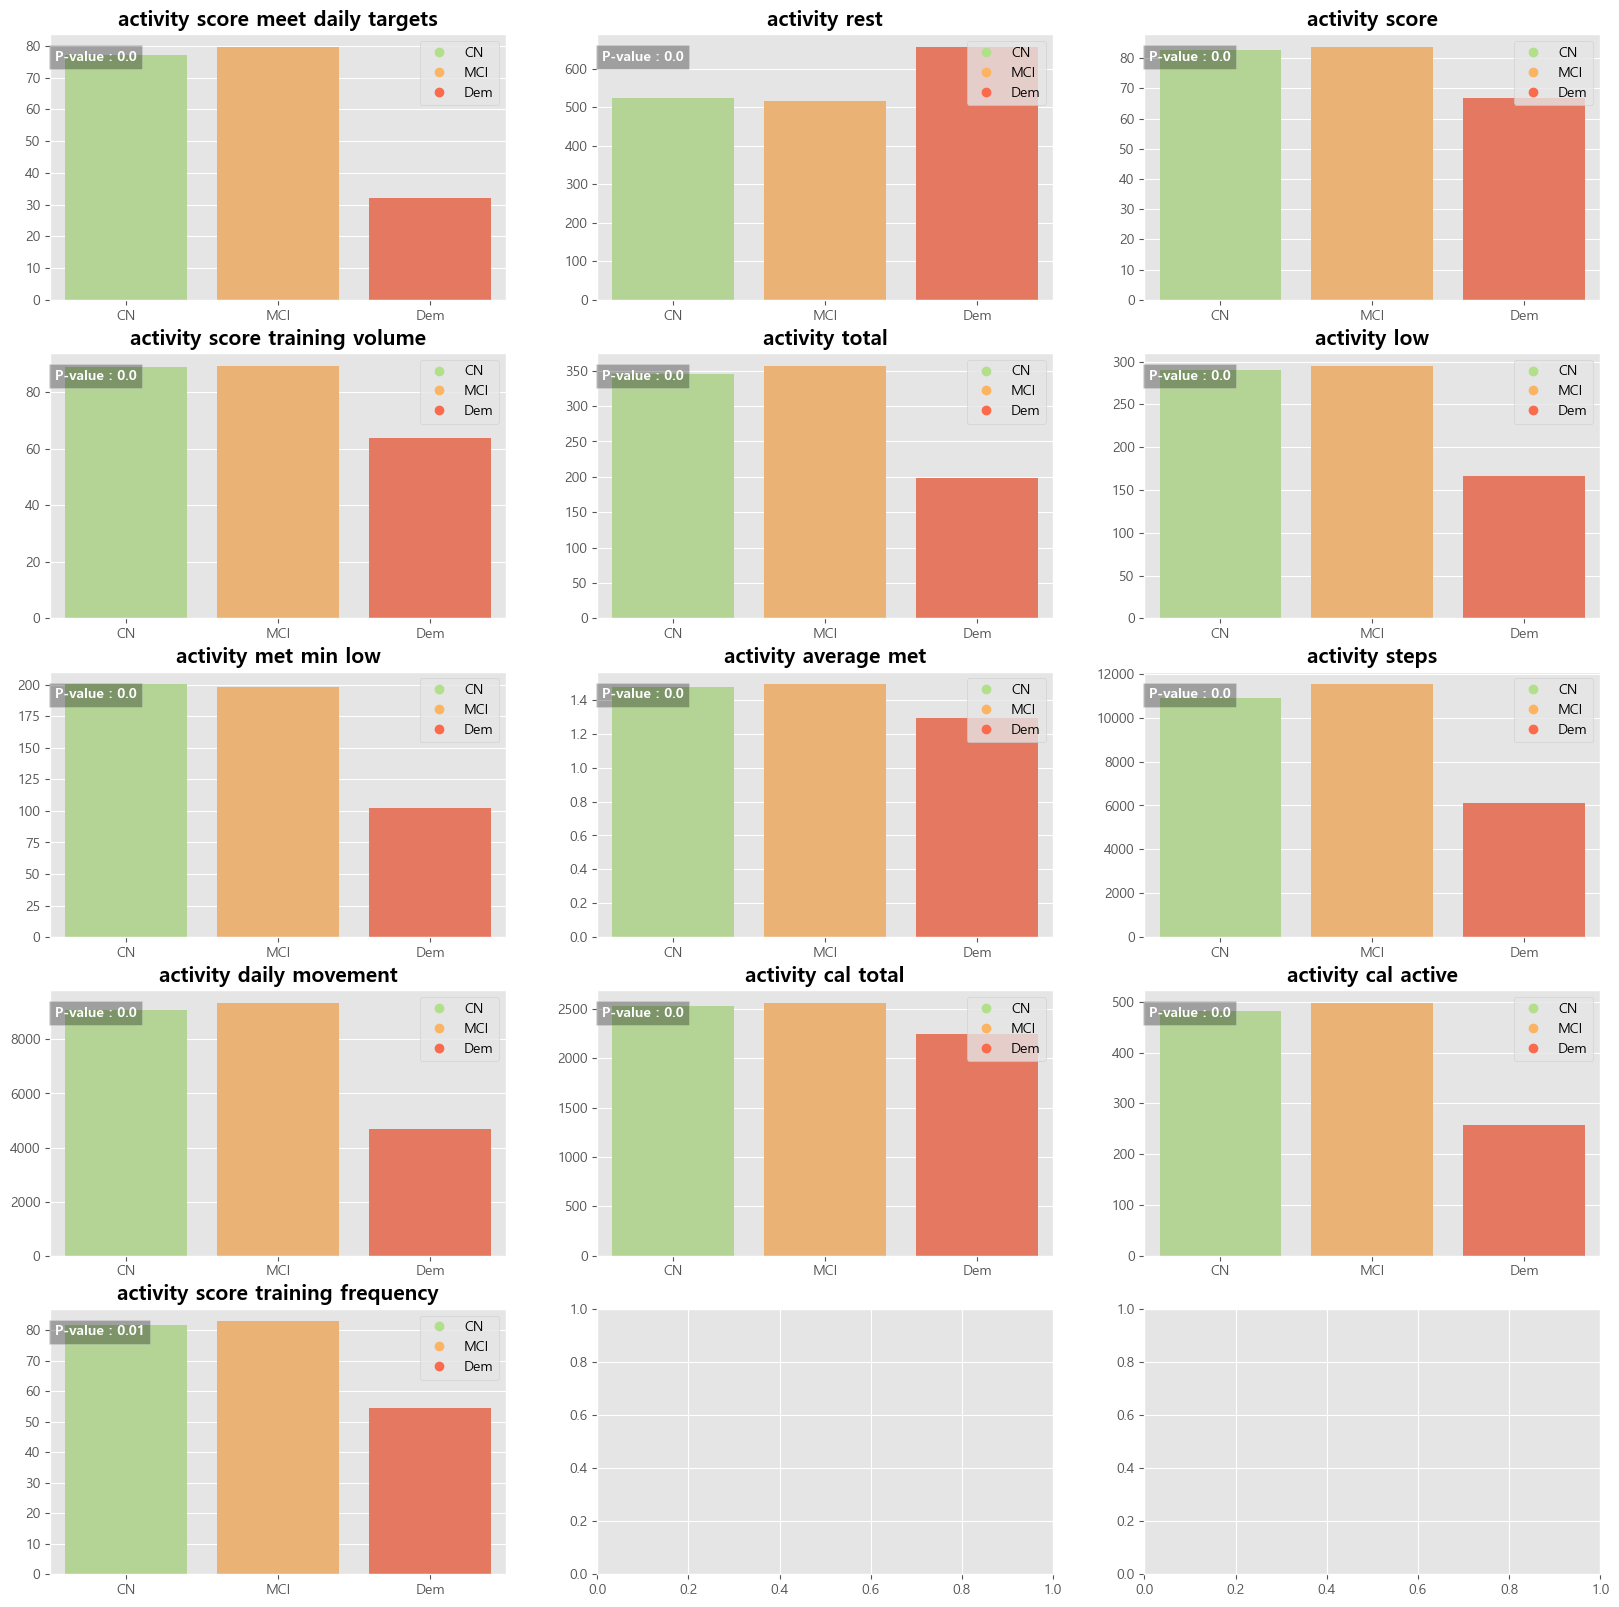

In [18]:
fig,ax = plt.subplots(ncols = 3,nrows = 5, figsize = (20,20))

target_colors = {'CN':'#b2df8a','MCI':'#fdb462','Dem':'#fb6a4a'}

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle = ' ') 
                        for label, color in target_colors.items()]

ax = ax.flatten()

colors = ['#b2df8a','#fdb462','#fb6a4a']

p_value = activity_pvalue['p-value'].values

for i,col in enumerate(activity_pvalue.index):
        
    p = round(p_value[i],2)
    
    sns.barplot(data = df,
                x = 'target',
                y = col,
                ax = ax[i],
                order = ['CN','MCI','Dem'],
                palette = ['#b2df8a','#fdb462','#fb6a4a'],
                ci = None)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(col.replace('_',' '), fontsize = 15, weight = 'bold')
    ax[i].legend(handles = legend_elements,
                frameon = True,
                loc = 'upper right')
    ax[i].text(0.01, 0.9, f'P-value : {p}', transform=ax[i].transAxes, fontsize=10, fontweight='bold', color='white', bbox=dict(facecolor='black', alpha=0.3))

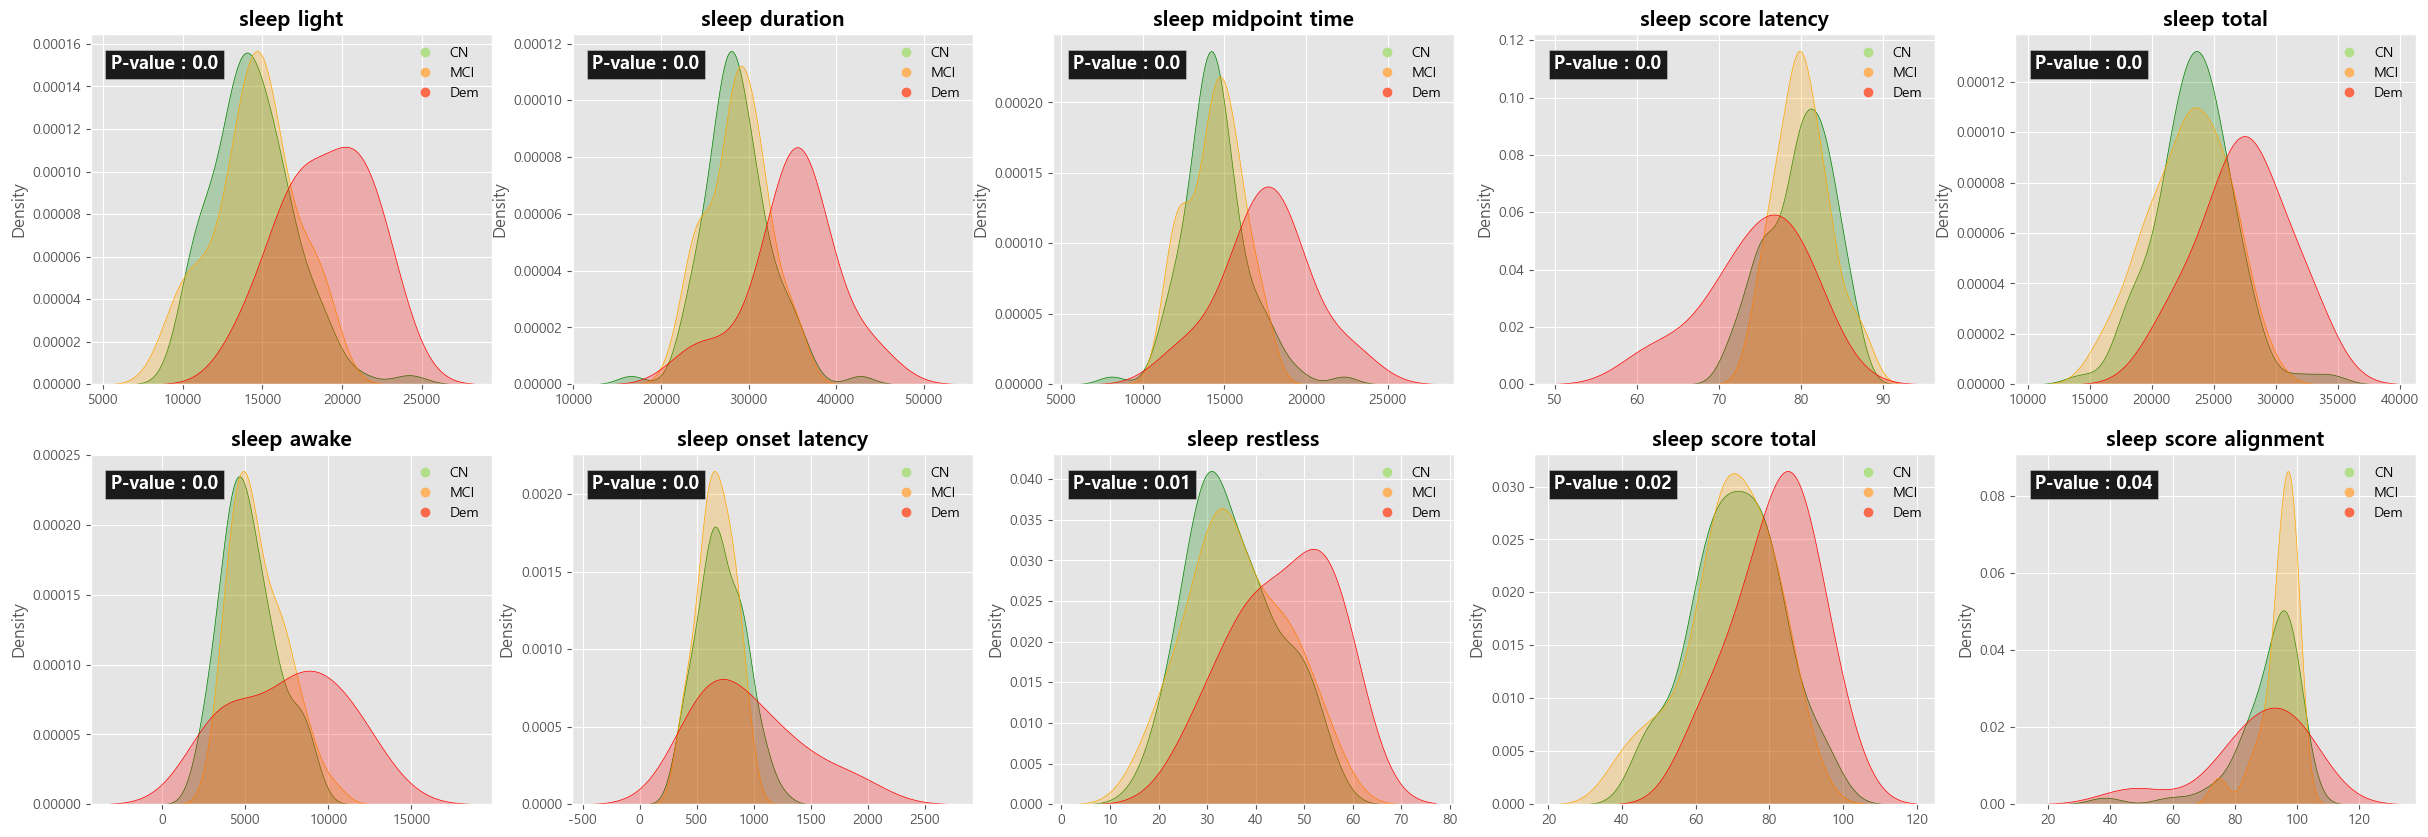

In [19]:
fig,ax = plt.subplots(ncols = 5,nrows = 2, figsize = (30,10))

target_colors = {'CN':'#b2df8a','MCI':'#fdb462','Dem':'#fb6a4a'}

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle = ' ') 
                        for label, color in target_colors.items()]

ax = ax.flatten()

colors = ['green','orange','red']


p_value = sleep_pvalue['p-value'].values

for i,col in enumerate(sleep_pvalue.index):
    for num,target in enumerate(['CN','MCI','Dem']):
        
        p = round(p_value[i],2)
        
        sns.kdeplot(data = df[df['target'] == target],
                    x = col,
                    ax = ax[i],
                    fill = True,
                    color = colors[num])
        ax[i].set_xlabel('')
        ax[i].set_title(col.replace('_',' '), fontsize = 15, weight = 'bold')
        ax[i].legend(handles = legend_elements,
                    frameon = False,
                    loc = 'upper right')
        # add text to ax
        ax[i].text(0.05, 0.9, f'P-value : {p}', transform=ax[i].transAxes, fontsize=13, fontweight='bold', color='white', bbox=dict(facecolor='black', alpha=0.5))

<aside>
💡 INSIGHT




**치매군 환자**가 **비 치매군**과 **경도 인지 장애군**에 비해 수면의 양과 관련된 요소들이 높았습니다. 

하지만 수면의 질과 연관된 변수들에 있어서는 (깊은 수면, 수면 점수 등) **비 치매군**에 비해 **치매군 환자**와 **경도 인지 장애군**이 ****낮은 양상을 보였습니다. 그 중 **치매군 환자**가 가장 낮았습니다.

</aside>

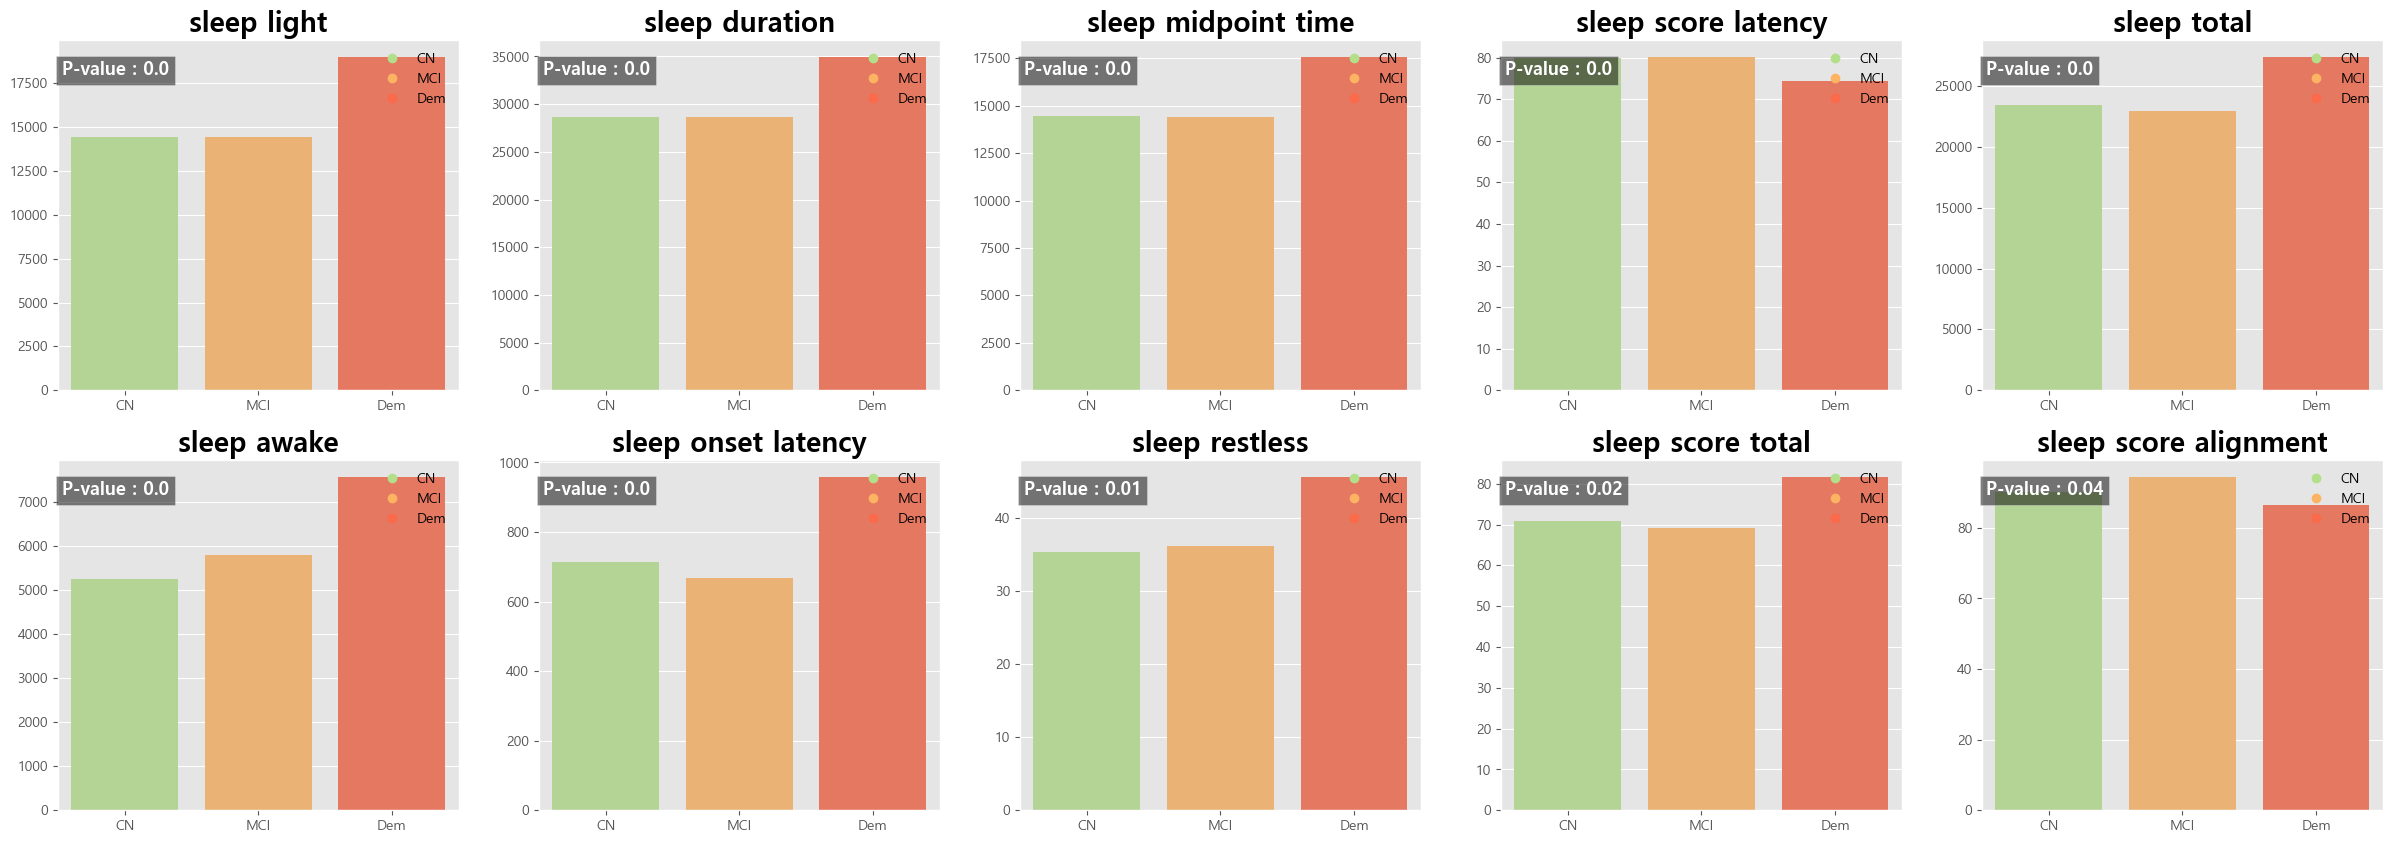

In [20]:
fig,ax = plt.subplots(ncols = 5,nrows = 2, figsize = (30,10))

target_colors = {'CN':'#b2df8a','MCI':'#fdb462','Dem':'#fb6a4a'}

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle = ' ') 
                        for label, color in target_colors.items()]

ax = ax.flatten()

colors = ['#b2df8a','#fdb462','#fb6a4a']

p_value = sleep_pvalue['p-value'].values

for i,col in enumerate(sleep_pvalue.index):
        
    p = round(p_value[i],2)
    
    sns.barplot(data = df,
                x = 'target',
                y = col,
                ax = ax[i],
                order = ['CN','MCI','Dem'],
                palette = ['#b2df8a','#fdb462','#fb6a4a'],
                ci = None)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(col.replace('_',' '), fontsize = 20, weight = 'bold')
    ax[i].legend(handles = legend_elements,
                frameon = False,
                loc = 'upper right')
    ax[i].text(0.01, 0.9, f'P-value : {p}', transform=ax[i].transAxes, fontsize=13, fontweight='bold', color='white', bbox=dict(facecolor='black', alpha=0.5))

# Correlationship

In [21]:
activity_corr = df[activity_cols].corr()

sleep_corr = df[sleep_cols].corr()

In [22]:
activity_mask = np.triu(np.ones_like(activity_corr))

sleep_mask = np.triu(np.ones_like(sleep_corr))

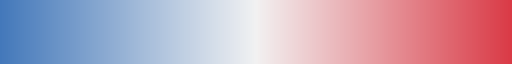

In [23]:
cmap = sns.diverging_palette(250,10, as_cmap = True) # 상관관계표에 사용할 cmap 객체 생성

cmap

In [24]:
bound = np.array(np.arange(-1,1,0.2))

norm = mpl.colors.BoundaryNorm(bound,ncolors = cmap.N) # cmap 의 경계 생성 

Text(0.5, 1.0, '활동내역 데이터 상관관계 히트맵')

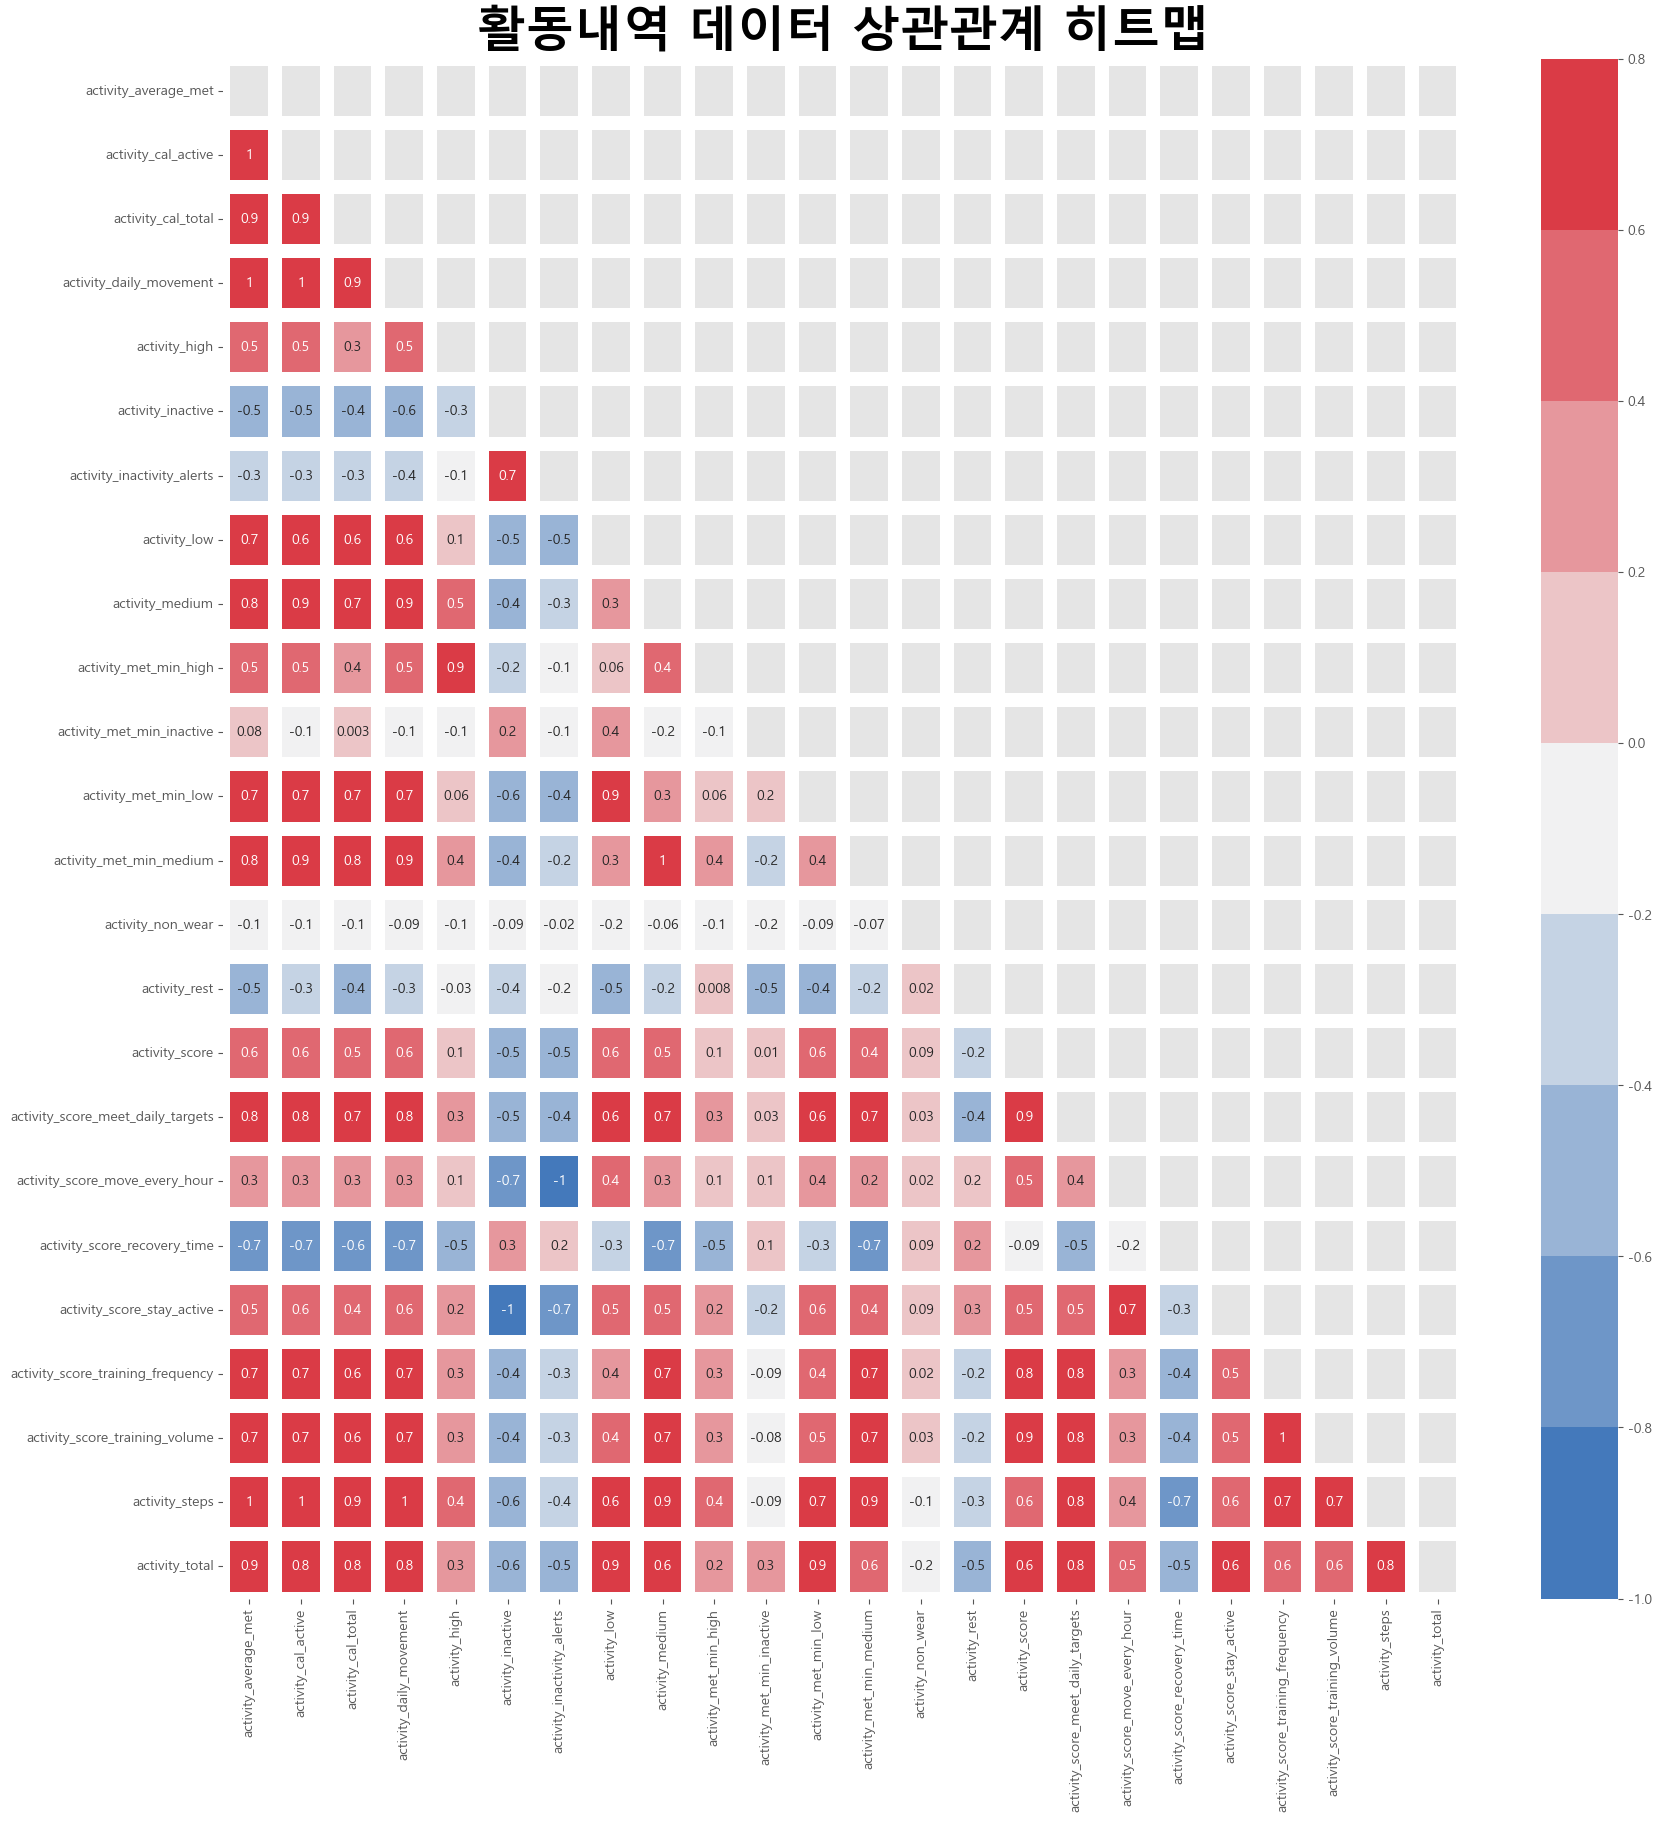

In [25]:
plt.figure(figsize = (20,20))
sns.heatmap(activity_corr,cmap = cmap, norm = norm, annot = True,mask = activity_mask,
            linewidths = 10, fmt = '.1g')
plt.title('활동내역 데이터 상관관계 히트맵',fontsize = 35, fontdict = {'fontstyle':'italic','weight':'bold'})

<aside>
💡 INSIGHT

대부분의 독립 변수간 상관관계를 보이고 있는 경우가 많습니다. (activity non waer 제외)

 이는 같은 내용을 표현하는 평가 지표들이 중복되어 나타남에 나타나는 현상 같습니다.
현재 데이터에서는 활동내역을 시간으로 평가하거나 , MET 로 평가하거나, score 로 평가 하고 있습니다. 

 또한 긍정과 부정을 모두 표현하는 변수들이 존재함에 따라 상관관계가 -0.9 이하로 나타나는 경우도 잦습니다. 예를 들어 하루 활동량과 하루 비활동량과 같은 변수를 뜻합니다.

 적절한 feature enginearing 이 필요해보입니다.

</aside>

Text(0.5, 1.0, '수면 내역 데이터 상관관계 히트맵')

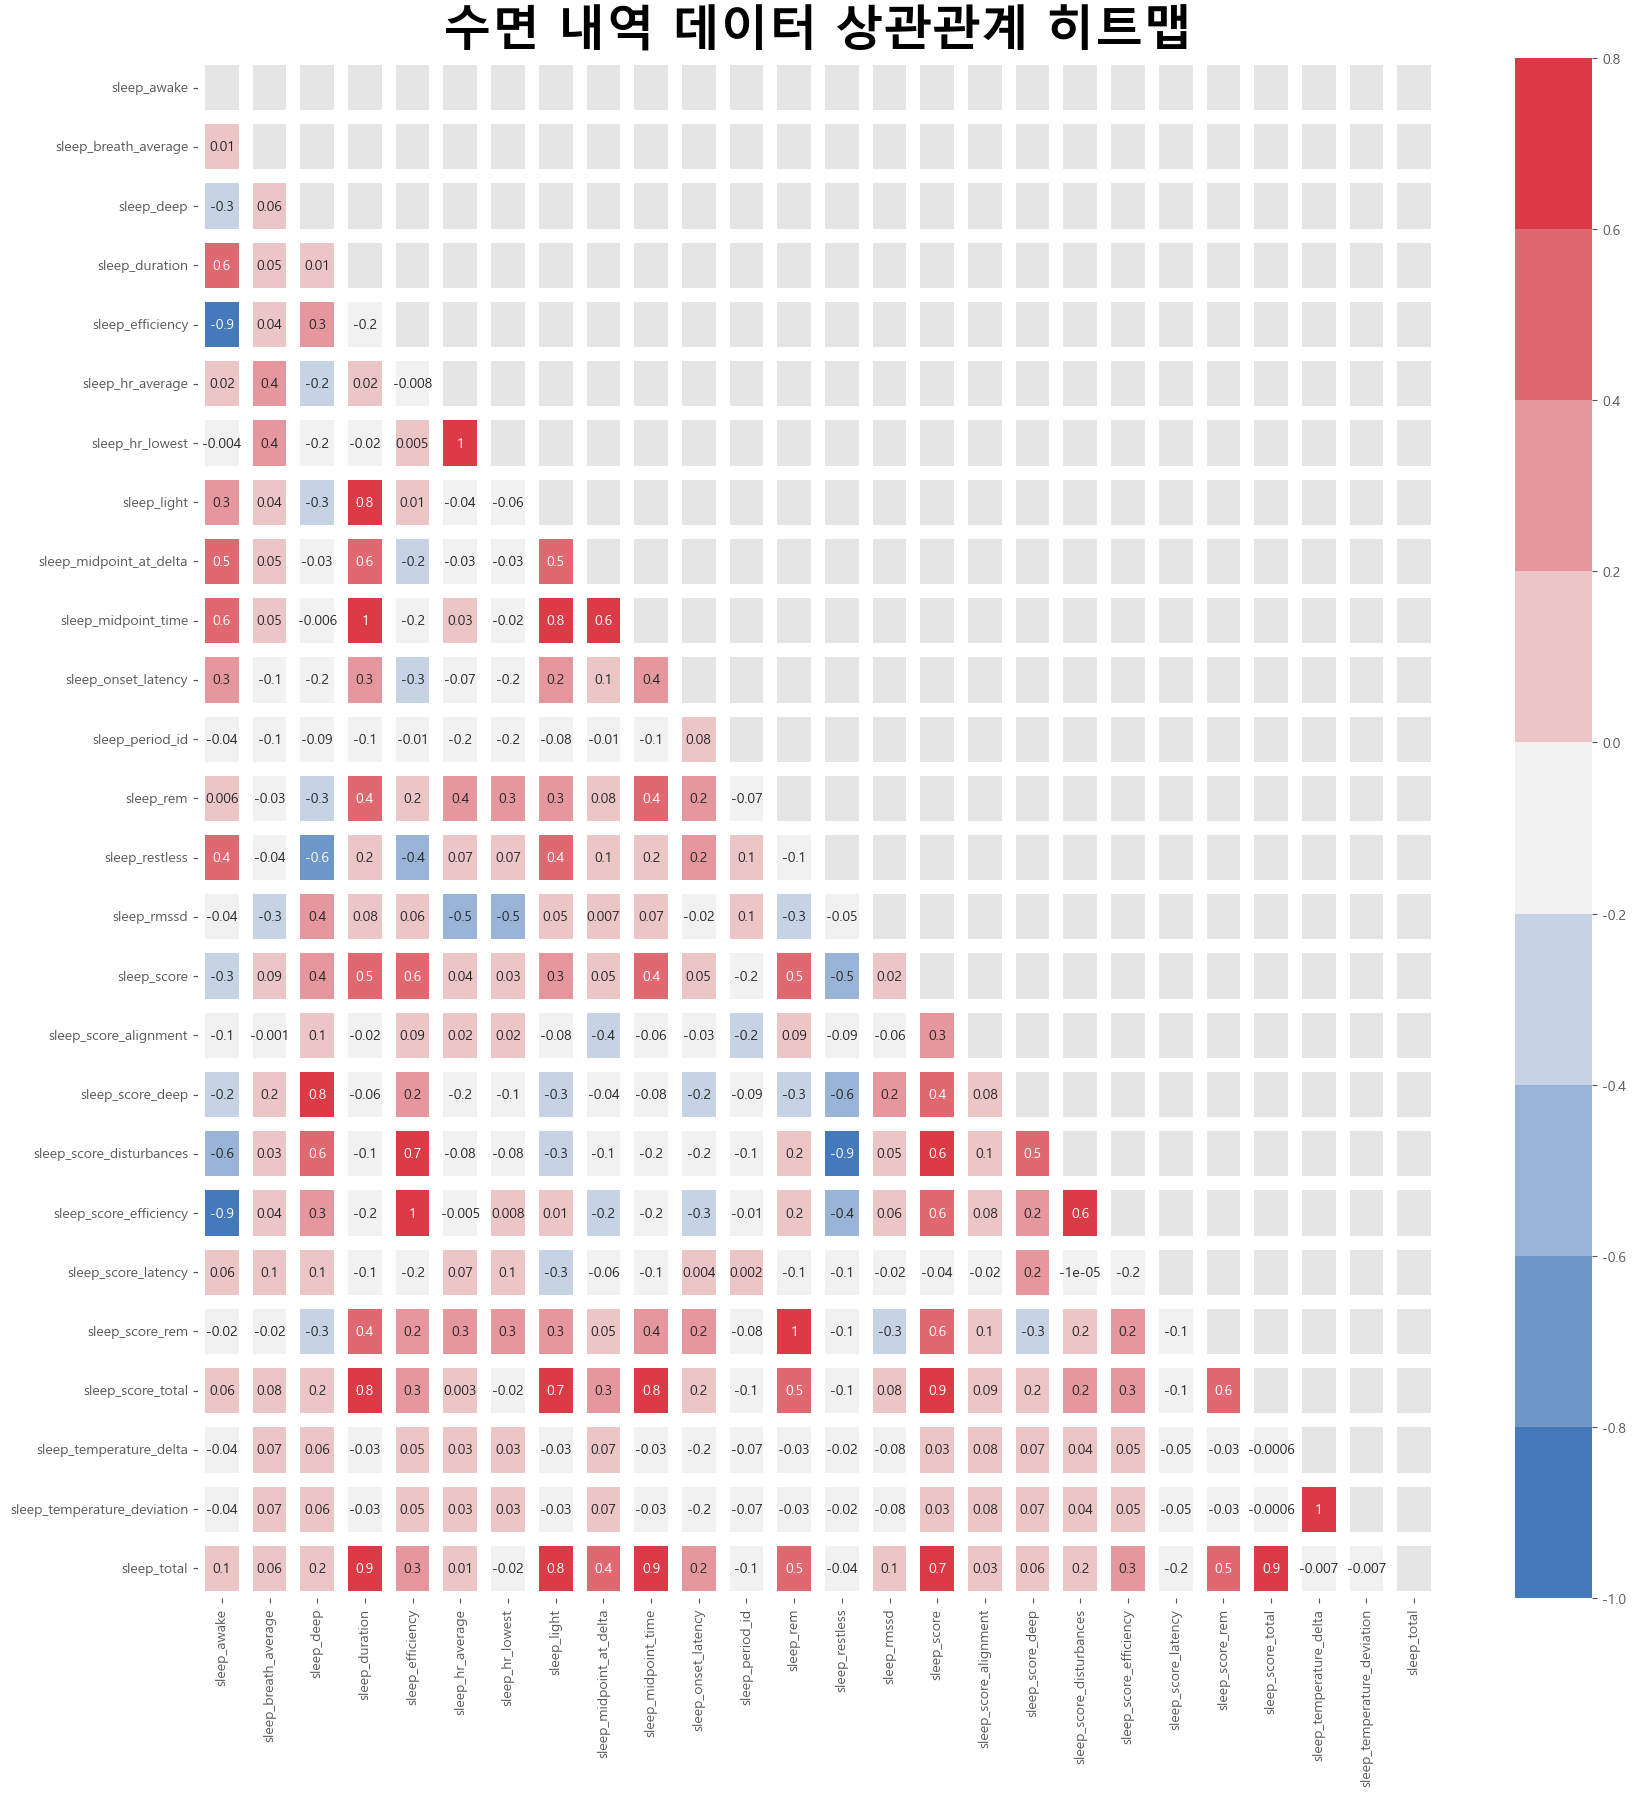

In [26]:
plt.figure(figsize = (20,20))
sns.heatmap(sleep_corr,cmap = cmap, norm = norm, annot = True,mask = sleep_mask,
            linewidths = 10, fmt = '.1g')
plt.title('수면 내역 데이터 상관관계 히트맵',fontsize = 35, fontdict = {'fontstyle':'italic','weight':'bold'})

<aside>
💡 INSIGHT

활동 내역 데이터와 다르게 상관관계가 강한 데이터들이 많지 않습니다.

0.8 이상의 매우 강한 상관 관계를 보이는 변수를 살펴보면 
1. 기상시간과 수면 효율성이 -0.9 로 매우 강한 음의 상관관계를 보입니다.
2. 수면 안정성과 수면 중 뒤척임 점수가 -0.9로 매우 강한 음의 상관 관계를 보입니다.
3. 수면 점수와 수면 중 뒤척임 정도가 -0.8로 매우 강한 음의 상관 관계를 보입니다.
4. 가벼운 수면 시간과 수면 중간점 시간이 0.8 로 매우 강한 양의 상관 관계를 보입니다.

수면과 관련된 독립 변수들간에서도 독립 변수의 조합으로 이뤄진 변수들이 많습니다.
이 또한 feature engiearing 의 필요성이 느껴집니다.

</aside>

# PCA

In [27]:
def do_pca(df, components, make_plot = True):
    
    pca = PCA(n_components = components) 
    
    X = df.drop('target',axis = 1)
    Y = df['target']
    
    pca_df = pd.DataFrame(pca.fit_transform(X))
    
    pca_df['target'] = Y
    
    
    if make_plot == True:
    
        target_colors = {'CN':'green', 'MCI':'orange','Dem':'red'}
        
        cmap = Y.map(target_colors)
        
        legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle = ' ') 
                        for label, color in target_colors.items()]
        
        if components == 2:
            
            fig, ax = plt.subplots()
            
            ax.scatter(pca_df[0],pca_df[1], color = cmap)
            ax.set_xticks([])
            ax.set_yticks([])
            
            
            ax.legend(handles = legend_elements,
                    frameon = True,
                    facecolor = 'white',
                    loc = 'upper right'
                    )
            
            fig.set_facecolor('black')
            
            
        if components == 3:
            
            fig,ax = plt.subplots(ncols = 3,
                                    figsize = (20,5),
                                    subplot_kw = {'projection':'3d'})
            
            view = [10,45,75]
            
            for i in range(3):
                
                ax[i].scatter(pca_df[0],pca_df[1],pca_df[2],color = cmap)
                ax[i].set_xticks([])
                ax[i].set_yticks([])
                ax[i].set_zticks([])
                ax[i].view_init(10,view[i])
                
                ax[i].set_facecolor('black')
                
            fig.set_facecolor('black')
            
            fig.legend(handles = legend_elements,
                    frameon = True,
                    facecolor = 'white',
                    bbox_to_anchor = (1,1),
                    )
            

    return pca_df
    

### 모든 변수를 고려한 차원 축소 결과

Text(0.5, 1.0, '차원 축소 후 살펴보는 데이터 패턴')

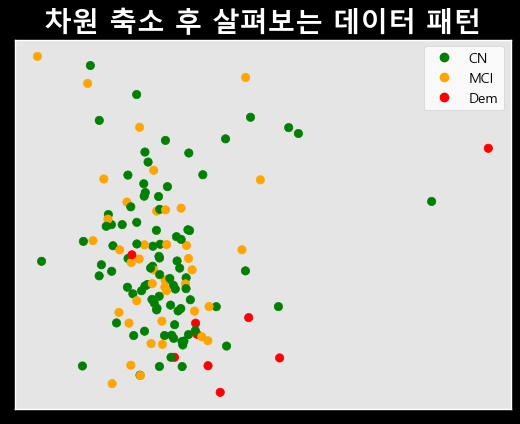

In [28]:
do_pca(df,2)
plt.title('차원 축소 후 살펴보는 데이터 패턴', color = 'white', fontsize = 20,weight = 'bold')

Text(0.5, 0.98, '모든 변수를 고려하여 차원 축소 후 살펴보는 데이터 패턴')

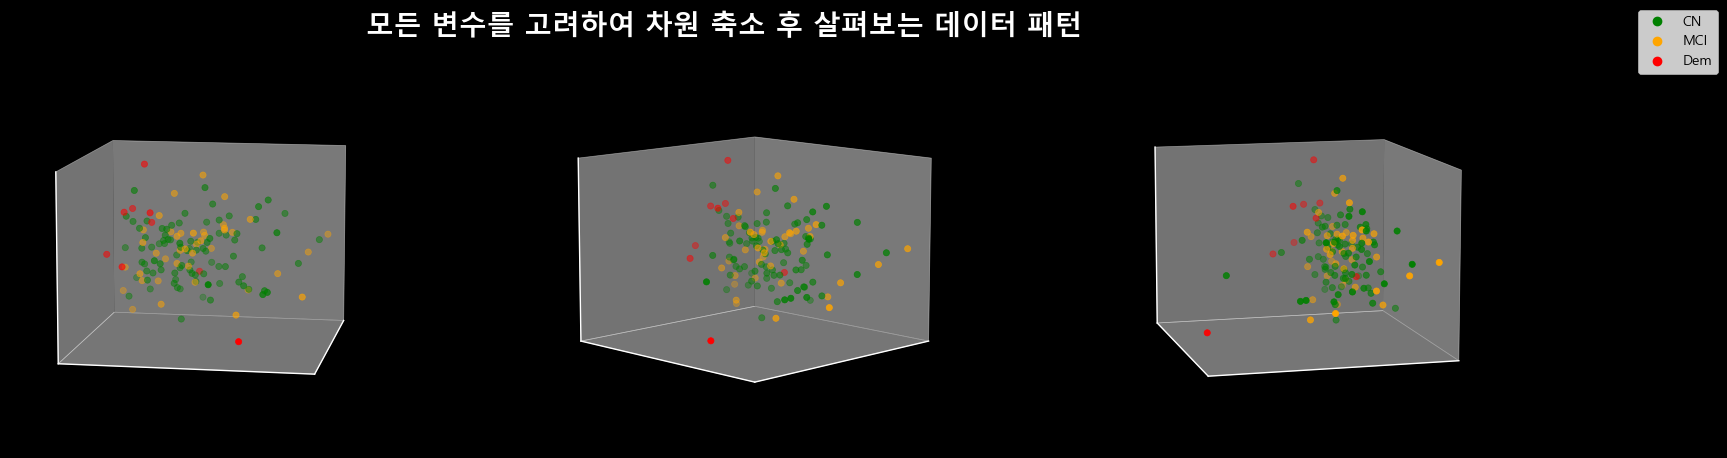

In [29]:
do_pca(df,3)
plt.suptitle('모든 변수를 고려하여 차원 축소 후 살펴보는 데이터 패턴', color = 'white', fontsize = 20,weight = 'bold')

<aside>
💡 INSIGHT

1. **비 치매군**과 **경도 인지 장애** 간 데이터가 패턴이 유사하게 보이는 것만 같습니다.가끔 두 클래스끼리 밀집된 지역이 있기도 하지만 대부분의 영역을 살펴 보았을 때 각 클래스 간 밀집되어 있는 모습을 볼 수 있습니다.
2. **치매군**은 이상치처럼 멀리 나와있는 경우가 많습니다. 중앙에 분포 된 두 개의 치매 군을 제외하고 말입니다.

</aside>

In [30]:
activity_anova_cols = activity_anova[activity_anova['p-value'] < 0.05].index.tolist()
sleep_anova_cols = sleep_anova[sleep_anova['p-value'] < 0.05].index.tolist()

full_anova = activity_anova_cols + sleep_anova_cols + ['target']

print(full_anova)

['activity_score_meet_daily_targets', 'activity_rest', 'activity_score', 'activity_score_training_volume', 'activity_total', 'activity_low', 'activity_met_min_low', 'activity_average_met', 'activity_steps', 'activity_daily_movement', 'activity_cal_total', 'activity_cal_active', 'activity_score_training_frequency', 'sleep_light', 'sleep_duration', 'sleep_midpoint_time', 'sleep_score_latency', 'sleep_total', 'sleep_awake', 'sleep_onset_latency', 'sleep_restless', 'sleep_score_total', 'sleep_score_alignment', 'target']


Text(0.5, 1.0, '차원 축소 후 살펴보는 데이터 패턴')

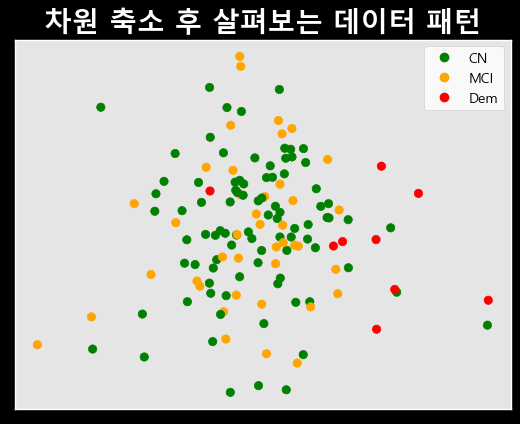

In [31]:
do_pca(df[full_anova],2)
plt.title('차원 축소 후 살펴보는 데이터 패턴', color = 'white', fontsize = 20,weight = 'bold')

Text(0.5, 0.98, '변수 선택 후 차원 축소 후 살펴보는 데이터 패턴')

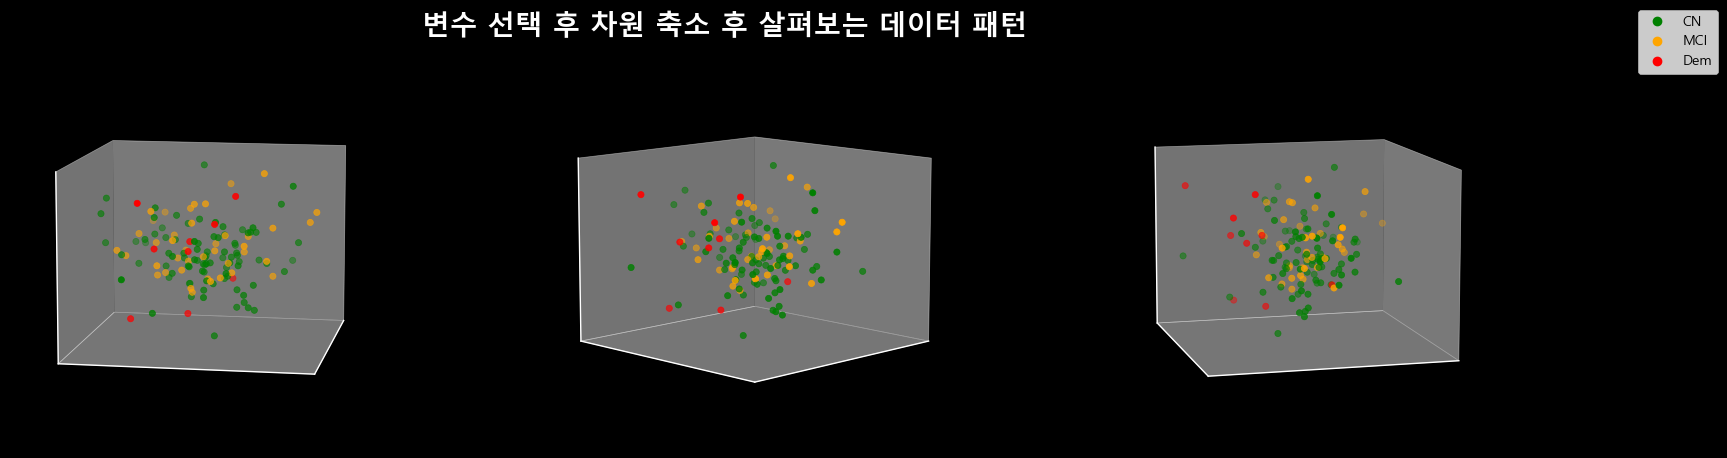

In [32]:
do_pca(df[full_anova],3)
plt.suptitle('변수 선택 후 차원 축소 후 살펴보는 데이터 패턴', color = 'white', fontsize = 20,weight = 'bold')

<aside>
💡 INSIGHT

1. **비 치매군**과 **경도 인지 장애** 간의 데이터 패턴의 차이가 조금 더 명확하게 드러나는 것 같습니다. 이 전 PCA 결과와 비교해보았을 때에 비해 **비 치매군**과 **경도 인지 장애군**의 거리가 조금 더 멀어졌습니다.
2. **치매군**은 변수 선택 전에 비해 더욱 눈에 띄게 이상치처럼 나와 있는 모습을 볼 수 있습니다.

</aside>

### 차원 축소 데이터 GIF 로 저장하기 

In [33]:
full_pca = do_pca(df,3,make_plot = False)
anova_pca = do_pca(df[full_anova],3,make_plot = False)

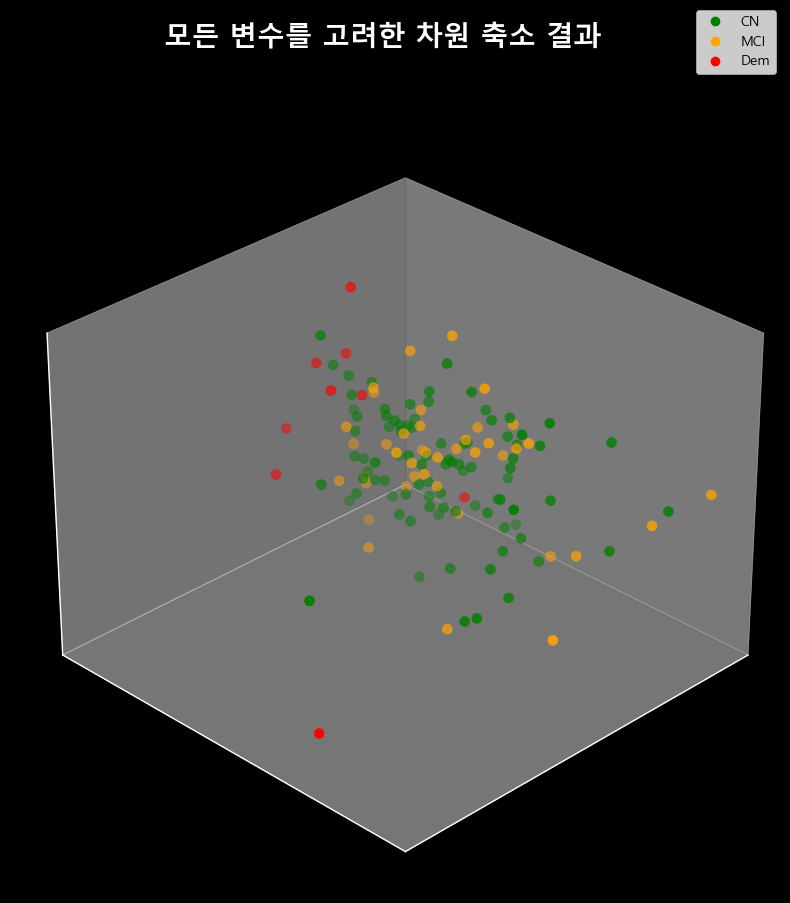

In [34]:
target_colors = {'CN':'green', 'MCI':'orange','Dem':'red'}

cmap = full_pca['target'].map(target_colors)

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle = ' ') 
                for label, color in target_colors.items()]


fullfig,ax = plt.subplots(subplot_kw = {'projection':'3d'},
                    figsize= (10,10))
fullfig.set_facecolor('black')
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
fullfig.suptitle('모든 변수를 고려한 차원 축소 결과', fontsize = 20, color = 'white',weight = 'bold')

fullfig.legend(handles = legend_elements,
        frameon = True,
        facecolor = 'white',
        bbox_to_anchor = (0.9,1),
        )

ax.view_init(30,45)
ax.scatter(full_pca[0],full_pca[1],full_pca[2], color = cmap, s = 50)


def full_update(i):

    cmap = full_pca['target'].map({'CN':'green','MCI':'orange','Dem':'red'})
        
    ax.view_init(30, i)
    scatter = ax.scatter(full_pca[0], full_pca[1], full_pca[2], s=30, color=cmap, alpha=0.5)
    return scatter,

In [35]:
ani = mpl.animation.FuncAnimation(fullfig, full_update, frames=range(0, 360, 10), repeat=True)
writer = PillowWriter(fps=5)
ani.save("full_pca.gif", writer=writer)

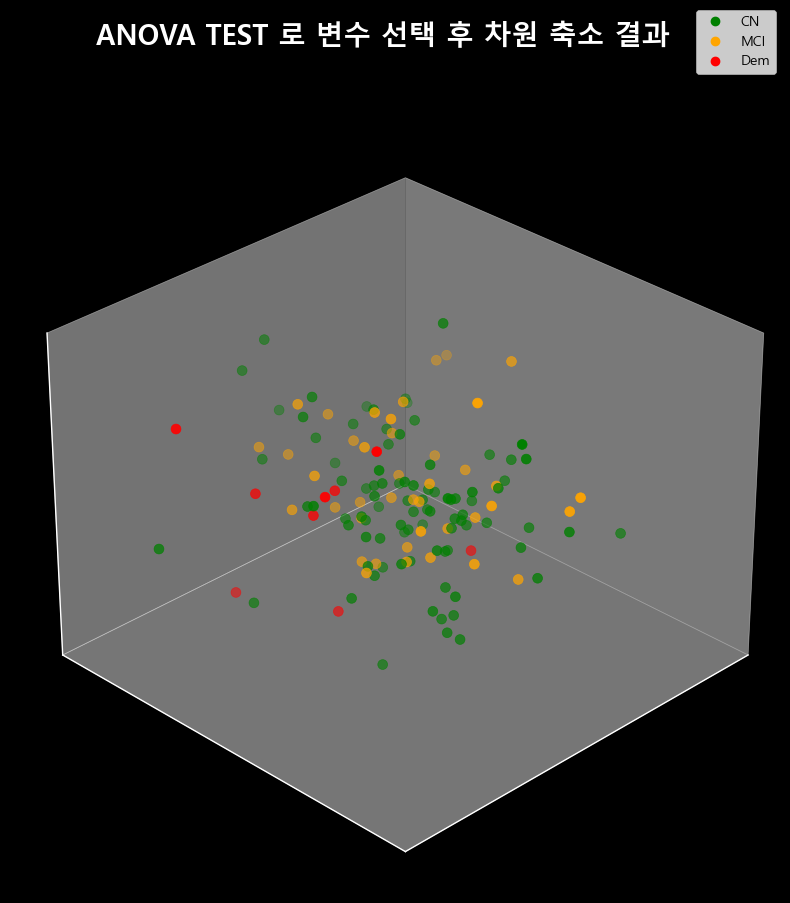

In [36]:
target_colors = {'CN':'green', 'MCI':'orange','Dem':'red'}

cmap = anova_pca['target'].map(target_colors)

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle = ' ') 
                for label, color in target_colors.items()]


anova_fig,ax = plt.subplots(subplot_kw = {'projection':'3d'},
                        figsize= (10,10))
anova_fig.set_facecolor('black')
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
anova_fig.suptitle('ANOVA TEST 로 변수 선택 후 차원 축소 결과', fontsize = 20, color = 'white',weight = 'bold')

anova_fig.legend(handles = legend_elements,
        frameon = True,
        facecolor = 'white',
        bbox_to_anchor = (0.9,1),
        )

ax.view_init(30,45)
ax.scatter(anova_pca[0],anova_pca[1],anova_pca[2], color = cmap, s = 50)


def anova_update(i):
                
        cmap = anova_pca['target'].map({'CN':'green','MCI':'orange','Dem':'red'})
                
        ax.view_init(30, i)
        scatter = ax.scatter(anova_pca[0], anova_pca[1], anova_pca[2], s=30, color=cmap, alpha=0.5)
        return scatter,

In [37]:
ani = mpl.animation.FuncAnimation(anova_fig, anova_update, frames=range(0, 360, 10), repeat=True)
writer = PillowWriter(fps=5)
ani.save("anova_pca.gif", writer=writer)

# 최종 변수 선택 

* 그룹간의 차이가 유의미한 변수들을 가지고 변수를 선택하도록 하자 

In [38]:
print('사용 할 변수명은')
print(full_anova)

사용 할 변수명은
['activity_score_meet_daily_targets', 'activity_rest', 'activity_score', 'activity_score_training_volume', 'activity_total', 'activity_low', 'activity_met_min_low', 'activity_average_met', 'activity_steps', 'activity_daily_movement', 'activity_cal_total', 'activity_cal_active', 'activity_score_training_frequency', 'sleep_light', 'sleep_duration', 'sleep_midpoint_time', 'sleep_score_latency', 'sleep_total', 'sleep_awake', 'sleep_onset_latency', 'sleep_restless', 'sleep_score_total', 'sleep_score_alignment', 'target']


In [39]:
df = df[full_anova]

df.head()

,activity_score_meet_daily_targets,activity_rest,activity_score,activity_score_training_volume,activity_total,activity_low,activity_met_min_low,activity_average_met,activity_steps,activity_daily_movement,...,sleep_duration,sleep_midpoint_time,sleep_score_latency,sleep_total,sleep_awake,sleep_onset_latency,sleep_restless,sleep_score_total,sleep_score_alignment,target
0,98.691489,698.500000,83.829787,99.521277,262.319149,191.234043,131.351064,1.416556,11501.936170,9319.223404,...,34593.829787,17310.638298,81.595745,26132.872340,8460.957447,957.446809,28.819149,76.946809,88.936170,CN
1,94.072464,564.449275,96.072464,98.492754,389.666667,310.898551,240.086957,1.544384,14450.695652,11927.536232,...,32773.913043,16302.173913,79.869565,26380.434783,6393.478261,726.956522,32.246377,81.884058,98.173913,CN
2,82.452055,517.780822,87.054795,94.232877,350.191781,292.534247,190.671233,1.505993,11622.027397,9587.383562,...,29812.602740,14591.095890,77.397260,22469.589041,7343.013699,847.808219,48.876712,66.095890,95.452055,CN
3,99.583333,631.733333,87.950000,100.000000,379.850000,284.166667,236.633333,1.560417,16226.683333,13412.883333,...,35677.000000,18214.000000,82.233333,27394.000000,8283.000000,846.500000,49.650000,79.150000,89.483333,CN
4,54.494624,416.043011,72.419355,72.086022,321.096774,293.892473,180.677419,1.452957,8017.204301,5915.397849,...,24140.000000,11944.838710,75.129032,20440.967742,3699.032258,373.225806,24.225806,57.860215,94.354839,MCI


* 선택한 변수끼리의 상관 관계

In [40]:
cmap = sns.diverging_palette(250,10, as_cmap = True)

boundary = np.array(np.arange(-1,1,0.2))

norm = mpl.colors.BoundaryNorm(boundary, cmap.N)

<AxesSubplot:>

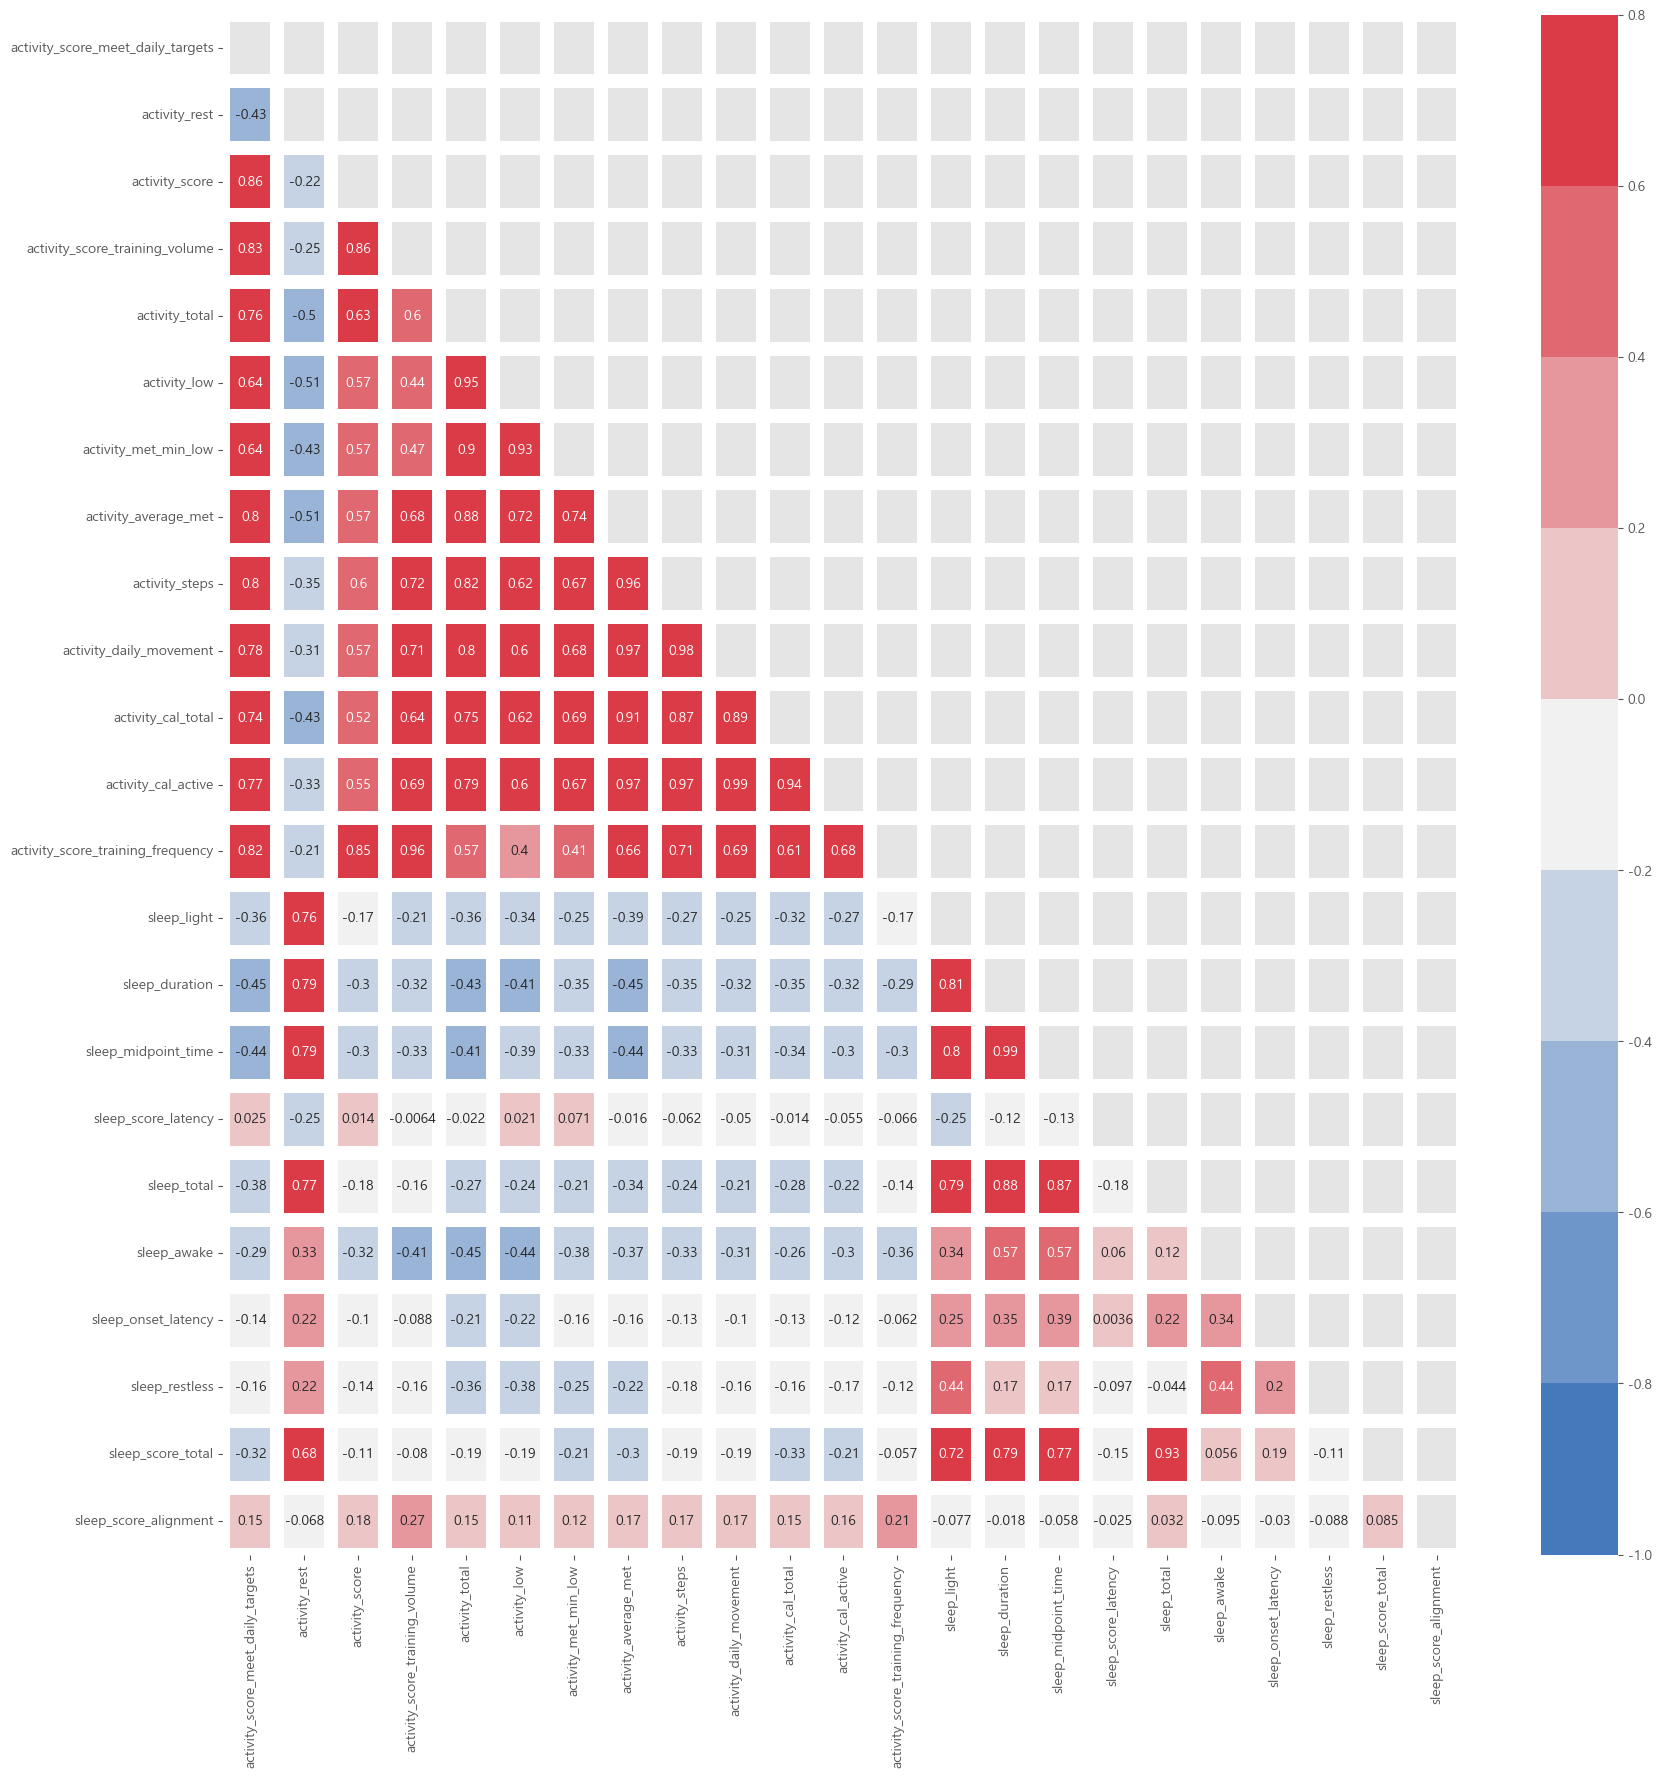

In [41]:
corr = df.corr()
mask = np.triu(np.ones_like(corr))

plt.figure(figsize = (20,20))

sns.heatmap(corr, mask = mask, annot = True, fmt = '.2g', 
                cmap = cmap , norm = norm, linewidths = 10)

<aside>
💡 INSIGHT

1. **비 활동성 시간** (acitivity rest)이 많을 수록 **수면 시간** (sleep total) 이 높았습니다**.** (상관 관계 0.8)
대상자들의 주 비활동성 시간은 수면 시간인 것으로 보입니다.

2. 활동내역과 관련된 데이터는 대부분 모두 강한 양의 상관 관계를 가지고 있습니다. ANOVA test 로 선택한 변수들은 모두 양의 활동량과 관련된 데이터들로 이뤄져있습니다.

 3. 수면과 관련된 데이터 중 강한 양의 상관 관계를 보이고 있는 데이터는 수면 점수와 총 수면량, 수면 시간, 가벼운 수면 시간입니다.

</aside>

In [42]:
df = df.drop('sleep_midpoint_time',axis = 1)

### 상관관계 높은 변수들끼리 회귀 플롯

* 보류하자. 너무 갯수도 많다.

In [43]:
# corr = df.corr()
# m = len(corr)

# cols = []
# indexes = []

# for i in range(1,m):
#     for j in range(i):
        
#         if np.abs(corr.iloc[i,j]) > 0.7:
#             cols.append(corr.columns[j])
#             indexes.append(corr.index[i]) # 상관관계가 -0.7 이하, 0.7 이상인 경우의 인덱스과 컬럼을 리스트 형태로 저장 

In [44]:
# target_colors = {'CN':'green','MCI':'orange','Dem':'red'}

# fig,ax = plt.subplots(ncols = 4, nrows = 2, figsize = (30,10))

# ax = ax.flatten()

# for i,(idx,col) in enumerate(zip(cols,indexes)):
    
#     cor = round(df[[idx,col]].corr().iloc[0,1],2)
    
#     for hue,color in target_colors.items():
        
#         sns.regplot(data = df[df['target'] == hue],
#                     x = idx,
#                     y = col,
#                     color = color,
#                     scatter_kws = {'alpha':0.5},
#                     line_kws = {'alpha':0.5, 'linewidth':2},
#                     ax = ax[i],
#                     ci = None)
        
#     idx = idx.replace('_',' ')
#     col = col.replace('_',' ')
#     ax[i].text(0.05,0.85,f'Correlationship \n\t {cor}',transform = ax[i].transAxes, size = 15,
#                 color = 'white',fontweight = 'bold',bbox=dict(facecolor='black', alpha=0.5))
#     ax[i].set_title(f'{col} & {idx}', size = 15, weight = 'bold')
#     ax[i].set_ylabel(col)
#     ax[i].set_xlabel(idx)
#     handles = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle='') 
#             for label, color in target_colors.items()]
#     ax[i].legend(handles=handles, loc='lower right')

<aside>
💡 INSIGHT

이전 상관관계표에서 봤던 독립 변수들은 비치매군, 경도인지장애군, 치매군 모두 상관관계가 동일하게 높은 모습을 볼 수 있습니다.

</aside>

# 모델링

### 평가 지표 설정 

- F1 micro는 모든 클래스를 하나의 큰 클래스로 보고 계산하는 방식입니다. 
- 즉, 모든 클래스의 TP, FP, FN을 더해서 전체적인 정밀도(precision)와 재현율(recall)을 계산합니다.
- 따라서, F1 micro는 모든 클래스의 샘플을 하나의 큰 풀(pool)로 묶어서 계산하므로 데이터의 불균형이 존재할 때 유용합니다.

* 모델링 전 데이터 전처리 

In [45]:
def preprocessing(df):
    
    X = df.drop('target',axis = 1)
    
    Y = df['target']
    
    Y = Y.map({'CN':0,'MCI':1,'Dem':2})
    
    for col in X.columns:
        
        min_col = np.min(X[col])
        max_col = np.max(X[col])
        
        X[col] = X[col].map(lambda x: (x - min_col)/(max_col - min_col)) # min_max_scaling
        
    return X,Y

In [46]:
test = test[full_anova].drop('sleep_midpoint_time',axis = 1) # 첫 번째 셀에서 나눠둔 test set

In [47]:
X,Y = preprocessing(df) # train set과 validaion set이 될 데이터

x_test,y_test = preprocessing(test) # test 세트

In [48]:
x_train,x_valid,y_train,y_valid = train_test_split(X,Y,stratify = Y,
                                                    random_state = 42,test_size = 0.2)

# Class weight 지정하기

* target 데이터의 분포는 불균형했기에 모델링 시 데이터 분포에 맞게 class weight 를 지정해주도록 하자 

Text(0.5, 1.0, 'Validation data label의 불균형')

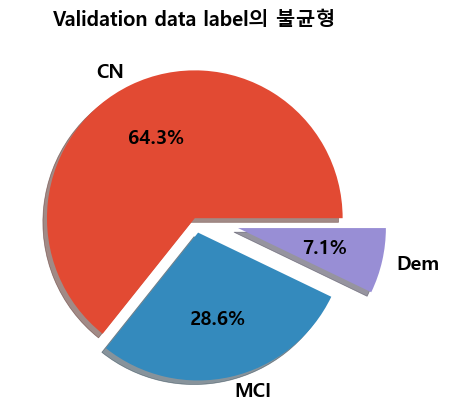

In [49]:
count = y_valid.value_counts()

percent = count / len(y_valid) * 100

label = percent.index.map({0:'CN',1:'MCI',2:'Dem'})
textprops = {'fontsize':14, 'color':'black','weight':'bold'}

plt.pie(percent,labels = label, autopct = '%1.1f%%', textprops = textprops,
        explode = [0,0.1,0.3],shadow = True);
plt.title('Validation data label의 불균형', fontdict = {'weight':'bold'})

## 화이트박스 모델 

In [123]:
def grid_search(model, params,feature,label,cv):
    
    global x_valid,y_valid
    
    valid_x,valid_y = x_valid,y_valid
    
    fit_params = {'early_stopping_rounds':15,
                    'eval_set': [(valid_x,valid_y)],
                    'eval_metric':'logloss'}
    
    model_name = str(model)
    
    for boost in ['XGB','LGBM','Cat']:
        if boost in model_name:
                        
            print(model_name,' 진행 중(early_stop 사용)') # 부스팅 계열은 빠른 진행을 위해 early stopping 기능을 사용하도록 하자 
            
            grid_model = GridSearchCV(estimator = model, param_grid = params, cv = cv, scoring = 'f1_micro',
                                        verbose = 0)
            
            grid_model.fit(feature,label,**fit_params)
            
            print(f'{str(model)[:-1]}의 최적의 하이퍼 파라미터는 : ', grid_model.best_params_,'\n')
            return grid_model.best_estimator_, grid_model.best_score_
        
        else:
            
            print(model_name + ' 진행 중')
            grid_model = GridSearchCV(estimator = model, param_grid = params, cv = cv, scoring = 'f1_micro',
                                        verbose = 0)
            
            grid_model.fit(feature,label)
            
            print(f'{str(model)[:-1]}의 최적의 하이퍼 파라미터는 : ', grid_model.best_params_,'\n')
            return grid_model.best_estimator_, grid_model.best_score_
        

In [124]:
logist_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 0.5, 1.0, 5.0, 10.0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'max_iter': [100, 500, 1000],
} # 로지스틱 회귀 분석

dt_params = {'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 5, 10,25],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
} # 의사결정 나무

svc_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'degree': [2, 3, 4],
}

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

In [125]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

model_list = [LogisticRegression(class_weight = 'balanced'),
                DecisionTreeClassifier(class_weight = 'balanced'),
                SVC(class_weight = 'balanced'),
                KNeighborsClassifier()]


params = [logist_params,dt_params,svc_params,knn_params]

models = {}
scores = {}


for i,model in enumerate(model_list):
    
    best_model, best_score = grid_search(model,params[i],x_train,y_train, cv = cv)
    
    models[str(best_model).split('(')[0]] = best_model
    scores[str(best_model).split('(')[0]] = round(best_score,3)

LogisticRegression(class_weight='balanced') 진행 중
LogisticRegression(class_weight='balanced'의 최적의 하이퍼 파라미터는 :  {'C': 1.0, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear'} 

DecisionTreeClassifier(class_weight='balanced') 진행 중
DecisionTreeClassifier(class_weight='balanced'의 최적의 하이퍼 파라미터는 :  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'} 

SVC(class_weight='balanced') 진행 중
SVC(class_weight='balanced'의 최적의 하이퍼 파라미터는 :  {'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'poly'} 

KNeighborsClassifier() 진행 중
KNeighborsClassifier(의 최적의 하이퍼 파라미터는 :  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} 



# 블랙박스 모델 

In [126]:
rf_params = {
    'n_estimators': [50,100,150],  
    'max_depth' : [5, 10, 15, 20],  
    'criterion' :['gini', 'entropy'],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4] 
} # 랜덤 포레스트 모델 params

xgb_params = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
} # XGBoost 모델 params

lgbm_grid = {
    'num_leaves': [31, 62, 127],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [8, 16],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
} # LGBM 모델 params

catboost_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
} # catboost 모델의 params


In [128]:
model_list = [RandomForestClassifier(class_weight = 'balanced'),
                XGBClassifier(n_estimators = 500,objective = 'multi:softmax'),
                LGBMClassifier(n_estimators = 500,objective = 'MultiClass',silent = True),
                CatBoostClassifier(n_estimators = 500,
                                    loss_function = 'MultiClass',
                                    silent = True)]

params = [rf_params,xgb_params,lgbm_grid,catboost_grid]

for i,model in enumerate(model_list):
    
    
    best_model, best_score = grid_search(model,params[i],x_train,y_train, cv = cv)
    
    model_name = str(best_model).split('(')[0]
    
    models[model_name] = best_model
    scores[model_name] = round(best_score,3)

# ROC curve

In [129]:
def avg_roc_curve(models,TEST_FEATURE,TEST_LABEL,ADD_TITLE_HEAD,ADD_TITLE_TAIL):
    
    fig,ax = plt.subplots(figsize = (8,8))
    
    real = label_binarize(TEST_LABEL, classes = [0,1,2]) # 다중 범주 문제를 roc_curve 로 그리기 위해 encoding
                                                    # 각 클래스 별 ROC curve를 그리게 된다.
    n = 3 # classes 의 unqiue 한 갯수                                                
    
    
    for num,(name,model) in enumerate(models.items()):
        
        if name == 'SVC':
            
            model = CalibratedClassifierCV(model) #SVC는 predict_proba 를 제공하지 않으므로 상속시킨 모델을 만들자
            
            model.fit(x_train,y_train)
            
            prob = model.predict_proba(TEST_FEATURE)
            
            fpr = {}
            tpr = {}
            
            fpr['micro'],tpr['micro'] , _ = roc_curve(real.ravel(), prob.ravel())
            AUC = round(auc(fpr['micro'], tpr['micro']),2)
            
            ax.plot(fpr['micro'],tpr['micro'], label = f'{name} \n AUC : {AUC}', lw = 2)
            
        else:
                        
            prob = model.predict_proba(TEST_FEATURE)
            
            fpr = {}
            tpr = {}

            fpr['micro'],tpr['micro'] , _ = roc_curve(real.ravel(), prob.ravel())
            AUC = round(auc(fpr['micro'], tpr['micro']),3)
            
            ax.plot(fpr['micro'],tpr['micro'], label = f'{name} \n AUC : {AUC}', lw = 2)
            
    ax.plot([0,1],[0,1], c = 'k', ls ='--', lw = '2')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{ADD_TITLE_HEAD} ROC CURVE \n ({ADD_TITLE_TAIL})')
        
    ax.legend(loc = 'lower right')

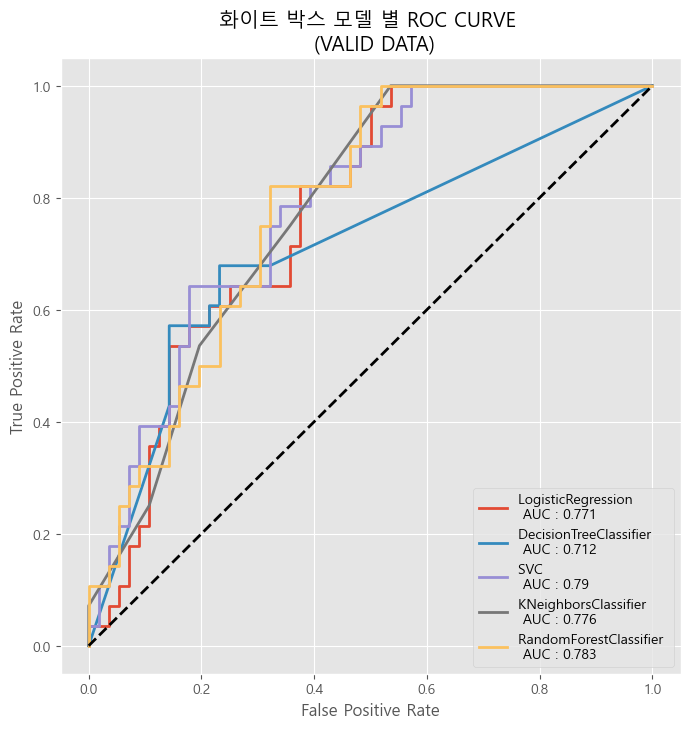

In [130]:
avg_roc_curve(models,x_valid,y_valid, '화이트 박스 모델 별','VALID DATA')

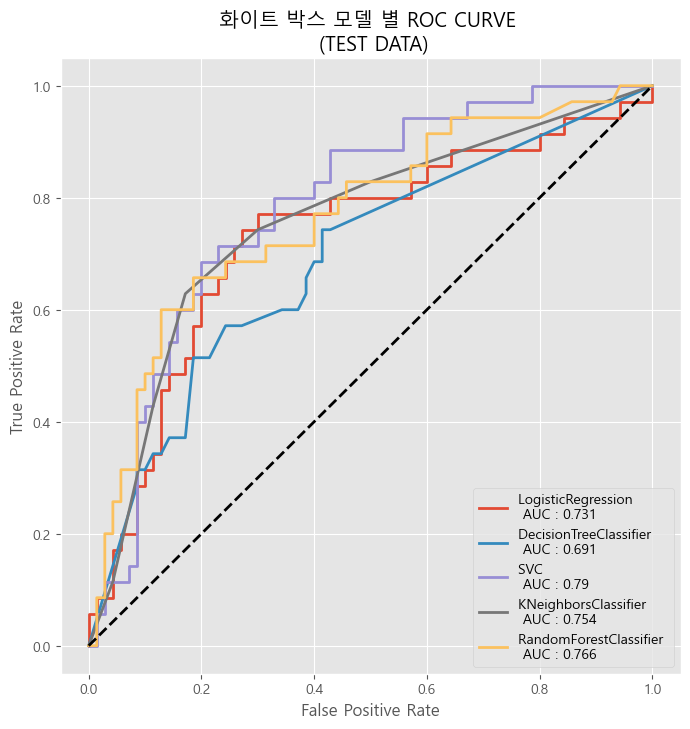

In [131]:
avg_roc_curve(models,x_test,y_test,'화이트 박스 모델 별','TEST DATA')

### Class 별 ROC curve

In [132]:
def roc_curve_plot(models,TEST_FEATURE,TEST_LABEL, ADD_TITLE):
    
    fig,ax = plt.subplots(ncols = len(models), figsize = (20,5))
    
    real = label_binarize(TEST_LABEL, classes = [0,1,2]) # 다중 범주 문제를 roc_curve 로 그리기 위해 encoding
                                                    # 각 클래스 별 ROC curve를 그리게 된다.
    n = 3 # classes 의 unqiue 한 갯수                                                
    
    
    for num,(name,model) in enumerate(models.items()):
        
        if name == 'SVC':
            
            model = CalibratedClassifierCV(model) #SVC는 predict_proba 를 제공하지 않으므로 상속시킨 모델을 만들자
            
            model.fit(x_train,y_train)
            
            prob = model.predict_proba(TEST_FEATURE)
            
            fpr = {}
            tpr = {}
            AUC = {}
            labels = {0:'CN',1:'MCI',2:'Dem'}
            
            for i in range(n):
                
                fpr[i],tpr[i],_ = roc_curve(real[:,i], prob[:,i])
                
                AUC[i] = round(auc(fpr[i],tpr[i]),2)
                
                ax[num].plot(fpr[i],tpr[i], label = f'{labels[i]} \n AUC : {AUC[i]}')
                
                ax[num].plot([0,1],[0,1], ls = '--', c = 'k', lw = '0.5')
                ax[num].set_title(name)
                ax[num].legend(loc = 'lower right')
                
                
            
        else:
                        
            prob = model.predict_proba(TEST_FEATURE)
            
            fpr = {}
            tpr = {}
            AUC = {}
            labels = {0:'CN',1:'MCI',2:'Dem'}
            
            for i in range(n):
                
                fpr[i],tpr[i],_ = roc_curve(real[:,i], prob[:,i])
                
                AUC[i] = round(auc(fpr[i],tpr[i]),2)
                
                ax[num].plot(fpr[i],tpr[i], label = f'{labels[i]} \n AUC : {AUC[i]}')
                
        
        ax[num].plot([0,1],[0,1], ls = '--', c = 'k', lw = '0.5')
        ax[num].legend(loc = 'lower right')
        ax[num].set_title(f'{name}의 class 별 ROC curve\n ({ADD_TITLE})')
        ax[num].set_xlabel('False Positive Rate')
        ax[num].set_ylabel('True Positive Rate')
        

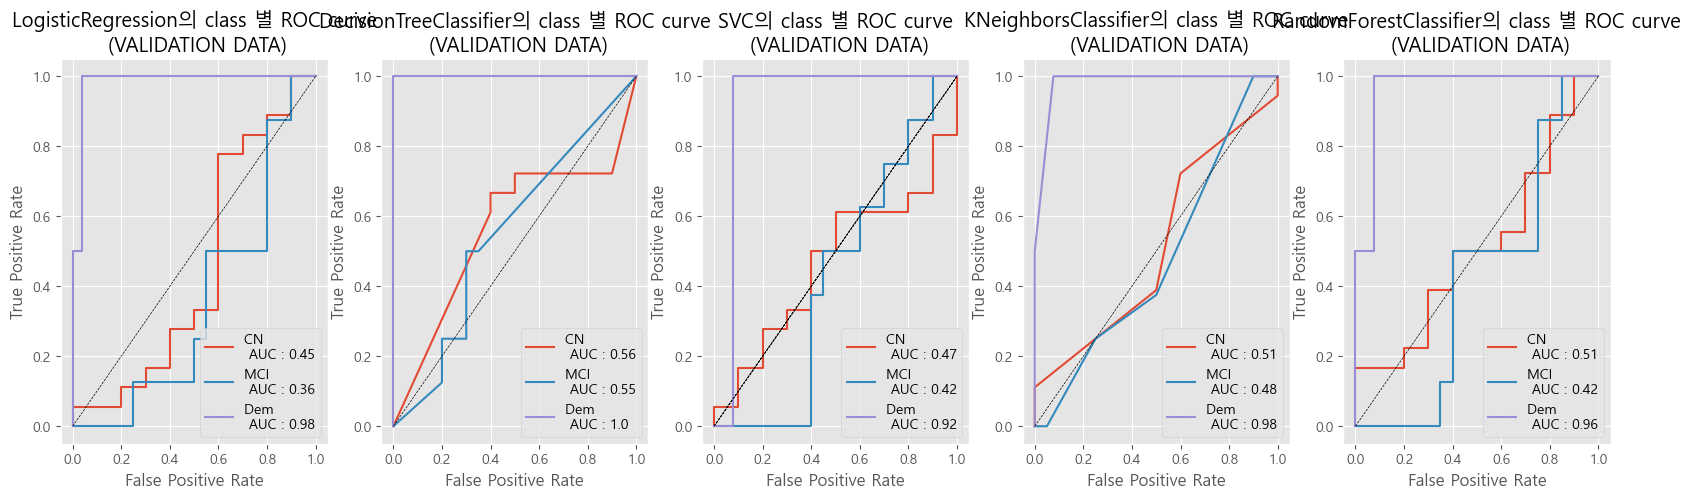

In [133]:
roc_curve_plot(models,x_valid,y_valid,'VALIDATION DATA')

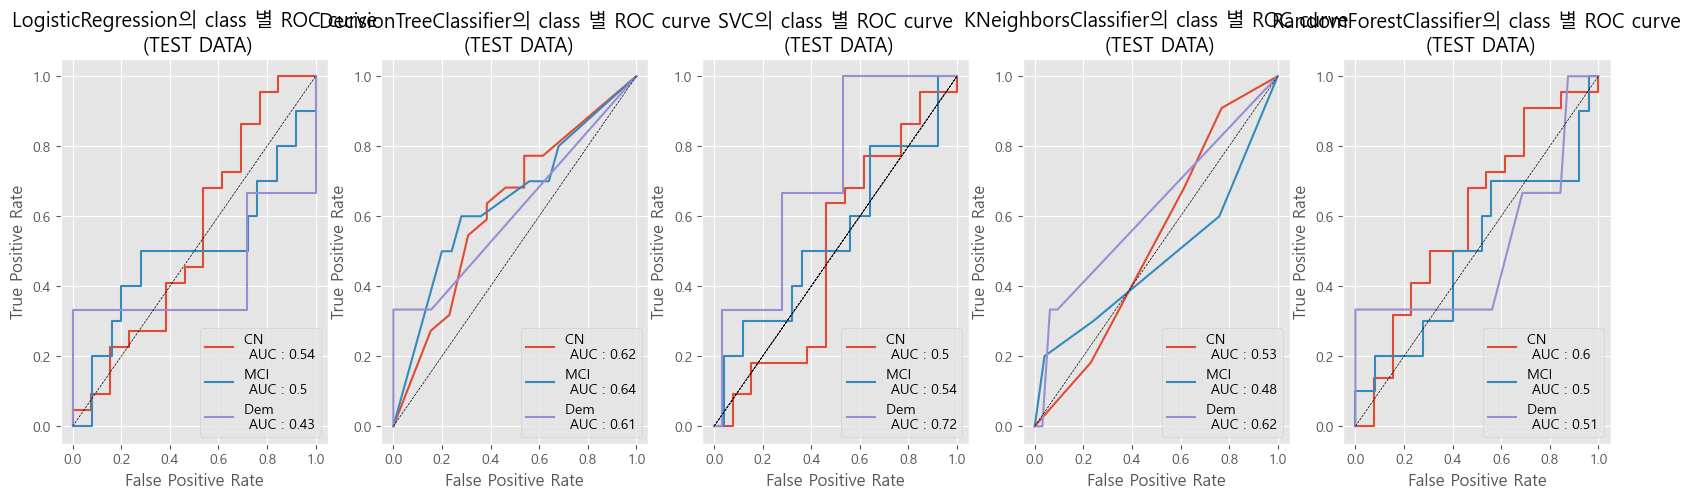

In [134]:
roc_curve_plot(models,x_test,y_test,'TEST DATA')

In [135]:
def f1_bar_plot(score):
    
    models = []
    score = []
    
    for key,value in scores.items():
        
        models.append(key)
        score.append(value)
        
    result = pd.DataFrame({'Model':models,
                    'F1_micro':score}).sort_values(by = 'F1_micro',
                                                    ascending = False)
    sns.barplot(data = result,
                x = 'F1_micro',
                y = 'Model')
    plt.xlim([0.5,0.7])
    plt.xlabel('F1 micro')

Text(0.5, 1.0, '교차 검증(5회) 시 평균 F1 micro 점수')

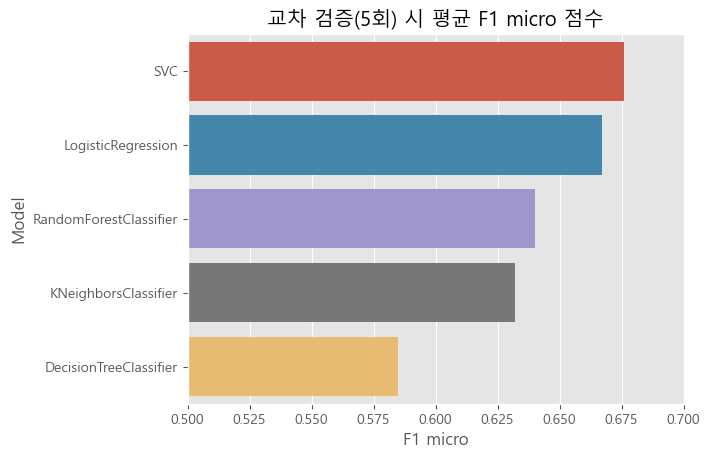

In [136]:
f1_bar_plot(scores)
plt.title('교차 검증(5회) 시 평균 F1 micro 점수')

# DNN

In [89]:
def create_den(INPUT_SHAPE,ACTIVATION,
               INITALIZER,FIRST_NODE,LAYERS,L2,DROPOUT_RATE,HIDDEN_NODE, OUTPUT_SHAPE):
    
    inputs = layers.Input(shape = INPUT_SHAPE)
    
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(FIRST_NODE, activation = ACTIVATION,
                                kernel_initializer = INITALIZER, kernel_regularizer = l2(L2))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    
    for layer in range(LAYERS):
        
        x = layers.BatchNormalization()(x)
        x = layers.Dense(HIDDEN_NODE, activation = ACTIVATION,
                                kernel_initalizer = INITALIZER, kernel_reguliarizer = l2(L2))(x)
        x = layers.Dropout(DROPOUT_RATE)(x)
        
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(OUTPUT_SHAPE, activation = 'softmax',
                                kernel_initalizer = GlorotNormal())(x)
    
    return keras.Models(inputs,outputs)